In [1]:
import sys
import os
home_directory_path = os.path.expanduser('~')
sys.path.append(home_directory_path +'/utils')

import explore_utils
from prepare_utils import split_data

import pandas as pd
import numpy as np

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import wrangle as w

from scipy import stats

In [2]:
df = w.prep_zillow()

In [3]:
df.columns

Index(['parcelid', 'id', 'bathrooms', 'bedrooms', 'sqft', 'fips', 'latitude',
       'longitude', 'regionidcity', 'regionidzip', 'property_value',
       'transaction_date', 'age', 'county'],
      dtype='object')

In [4]:
train, _, _ = split_data(df, validate_size=.15, test_size=.15, 
                         stratify_col='county', random_state=123)

In [5]:
train = train[['bathrooms', 'bedrooms', 'county',
               'sqft', 'age', 'property_value']]

In [6]:
explore_utils.get_cat_and_cont_cols(train)

(['bathrooms', 'bedrooms', 'county'], ['sqft', 'age', 'property_value'])

**Univariate Analysis**

- categorical counts and frequencies
- numerical stats for continuous features and target

BATHROOMS


bathrooms  Count  Frequency
0       2.00  14578       0.46
1       3.00   6780       0.22
2       1.00   5271       0.17
3       2.50   2649       0.08
4       4.00   1066       0.03
5       1.50    552       0.02
6       3.50    499       0.02

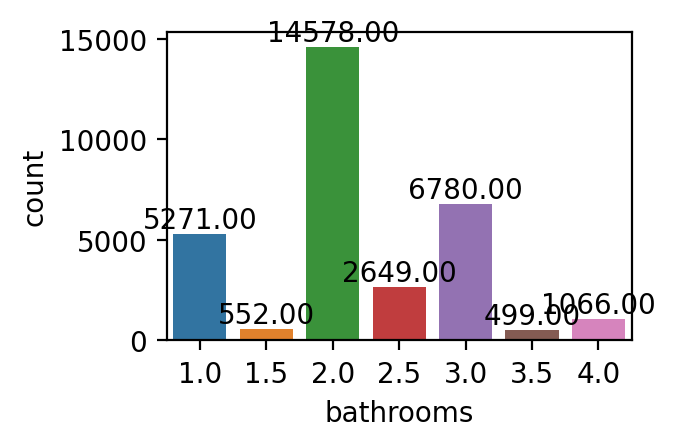


BEDROOMS


bedrooms  Count  Frequency
0         3  15014       0.48
1         4   9466       0.30
2         2   5098       0.16
3         5   1817       0.06

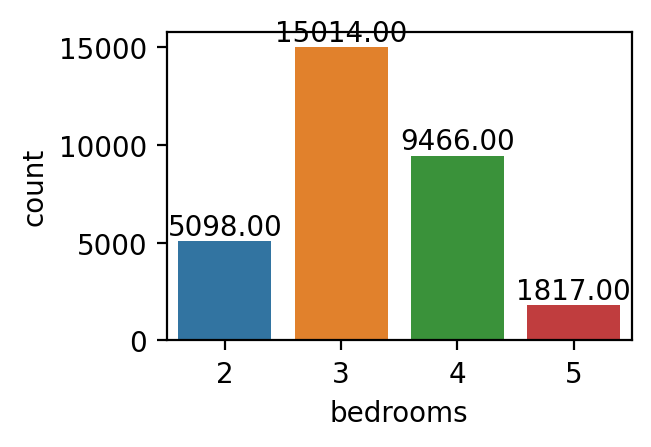


COUNTY


county  Count  Frequency
0       LA  20117       0.64
1   Orange   8513       0.27
2  Ventura   2765       0.09

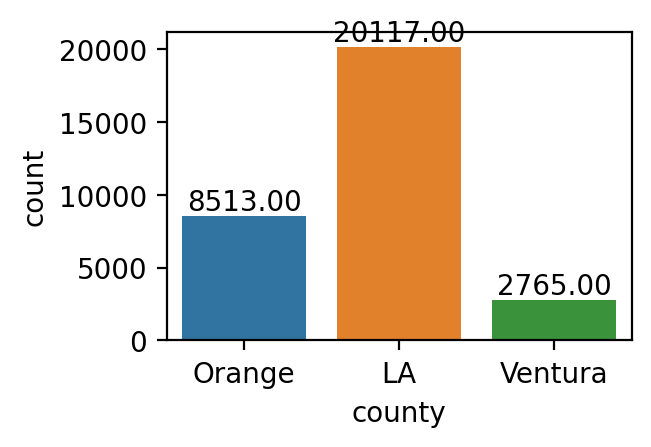

In [7]:
explore_utils.explore_univariate_categorical_cols(train)

Descriptive Stats:



sqft  property_value      age
count 31395.00        31395.00 31395.00
mean   1777.20       414625.58    52.50
std     676.90       285793.91    21.14
min     500.00        50067.00     1.00
25%    1277.00       196456.00    39.00
50%    1627.00       359103.00    55.00
75%    2144.00       559000.00    65.00
max    4997.00      1500000.00   105.00

------------------------------------------------------------ 
 SQFT 

Most Frequent Values:
1120    77
1200    76
1176    57
Name: sqft, dtype: int64


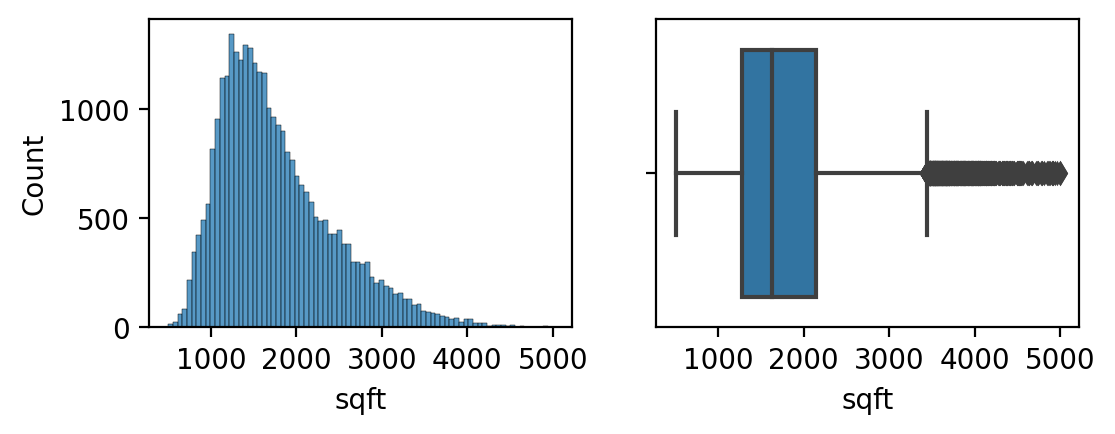


------------------------------------------------------------ 
 PROPERTY_VALUE 

Most Frequent Values:
600000    22
455000    20
550000    18
Name: property_value, dtype: int64


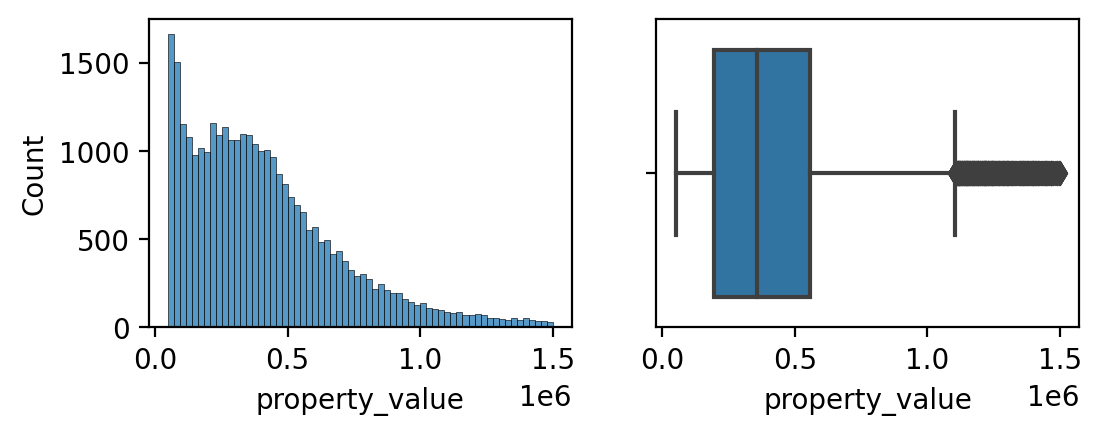


------------------------------------------------------------ 
 AGE 

Most Frequent Values:
61    1204
66    1033
62     981
Name: age, dtype: int64


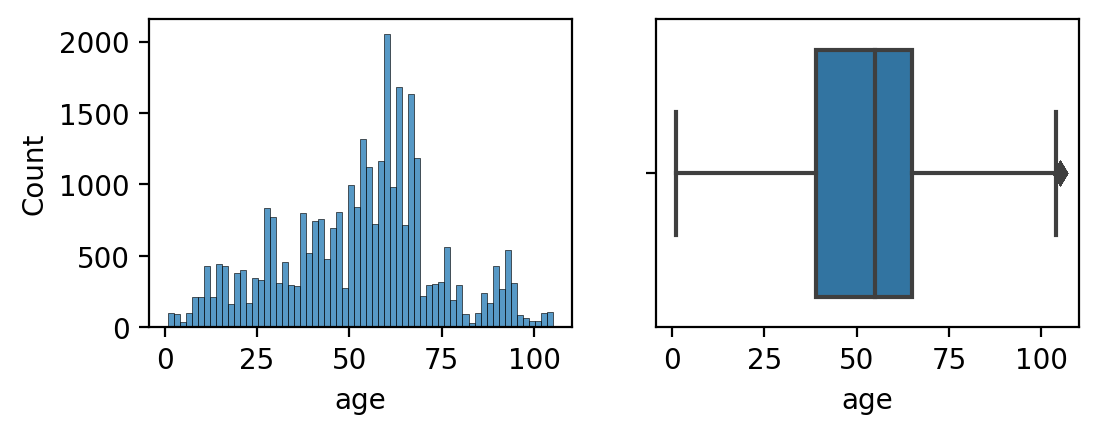

In [8]:
explore_utils.explore_univariate_continuous_cols(train,
                                                 cont_cols=['sqft', 'property_value', 'age'])

Notes:

- sqft and value distributions are right-skewed.

- Typical home:
    - is 3bed/2bath
    - in LA county
    - 1000-2000 sqft
    - 100k-500k

Find target distribution

- property value follows a distribution similar to poisson or gamma

<Axes: ylabel='Count'>

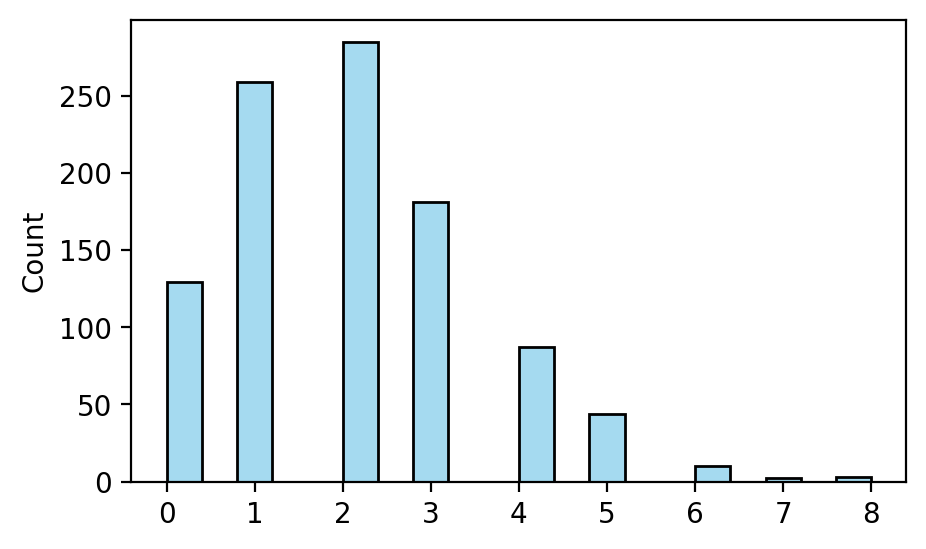

In [9]:
plt.figure(figsize=(5,3))
# Generate random data following a Poisson distribution
lambda_param = 2  # Poisson distribution parameter
data = np.random.poisson(lambda_param, size=1000)

# Plot the distribution using Seaborn
sns.histplot(data, color='skyblue')

<Axes: ylabel='Count'>

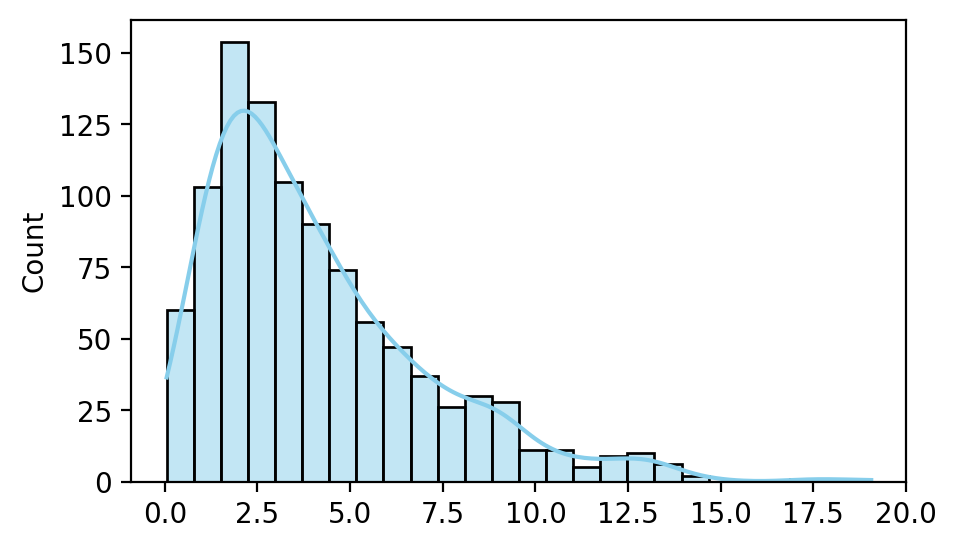

In [10]:
plt.figure(figsize=(5,3))
# Generate random data following a Gamma distribution
shape_param = 2  # Shape parameter (alpha)
scale_param = 2  # Scale parameter (beta)
data = np.random.gamma(shape_param, scale=scale_param, size=1000)

# Plot the distribution using Seaborn
sns.histplot(data, kde=True, color='skyblue')


**Bivariate Stats**

- A. Property value correlations with continuous features
- B. Property value for each category

A.

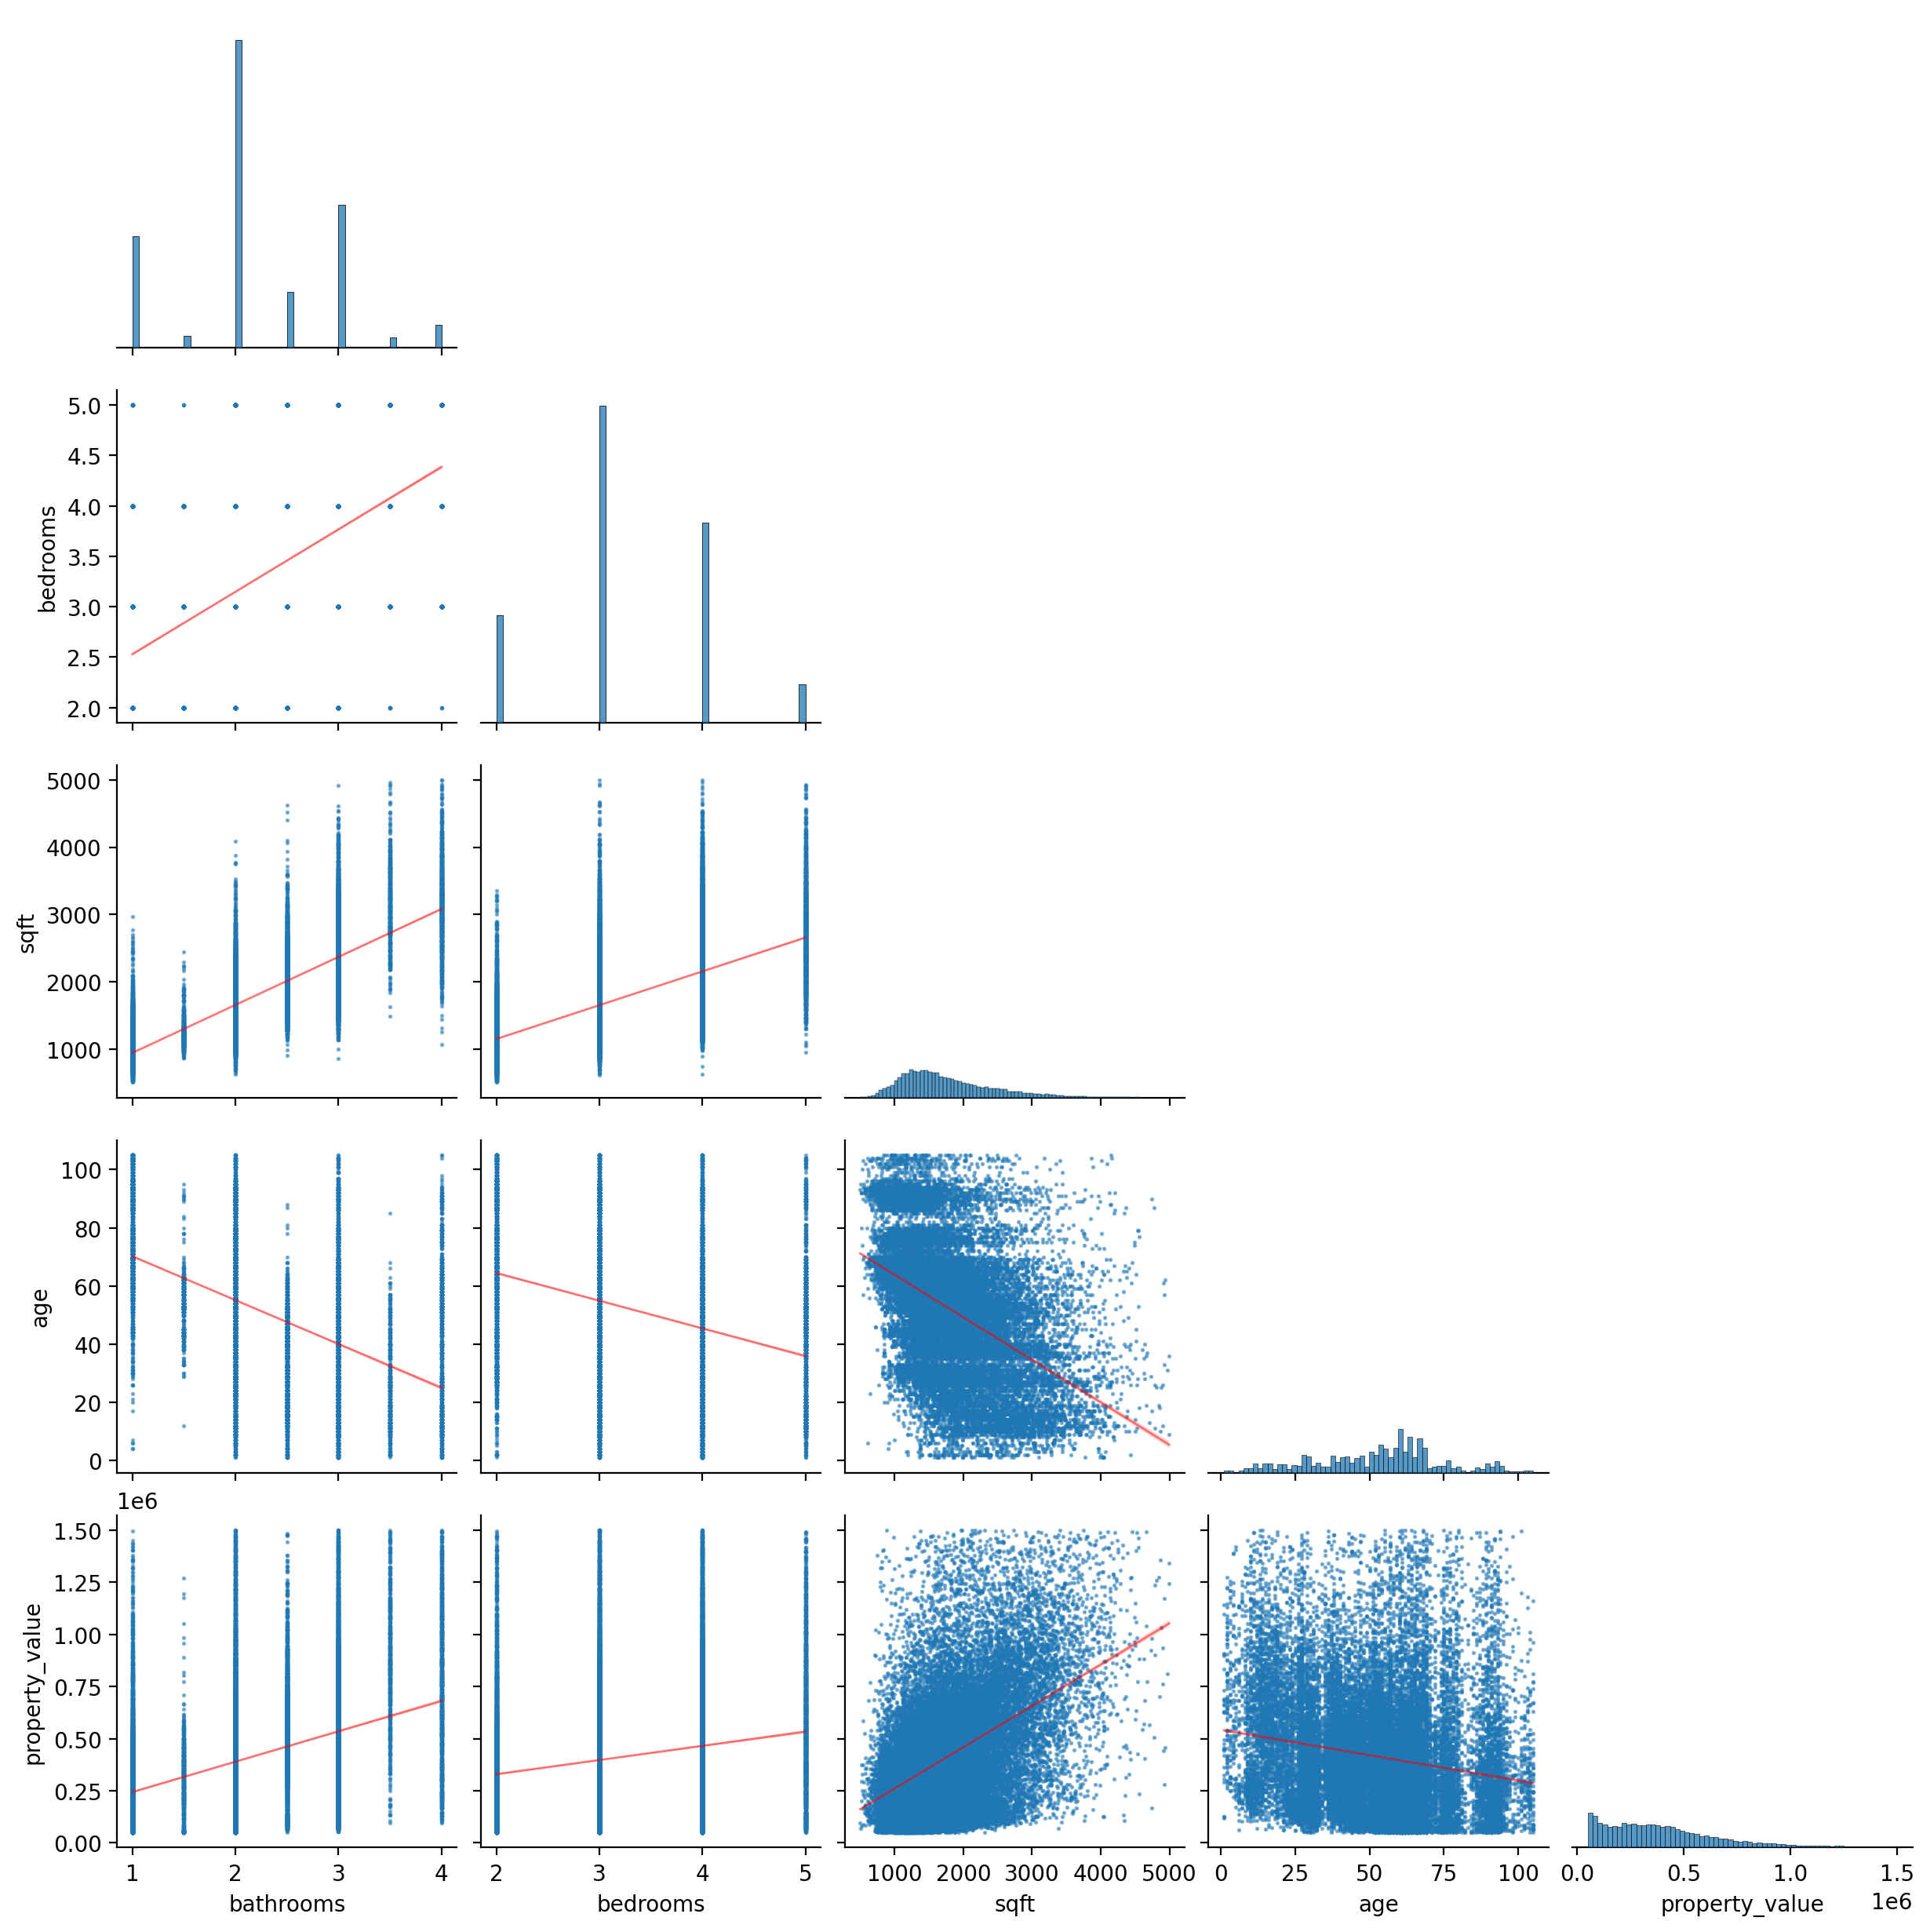

In [11]:
sns.pairplot(data=train, kind='reg', corner=True,
             plot_kws={'scatter_kws':{'s':1, 'alpha':.5},
                       'line_kws':{'linewidth':1, 'alpha':.5, 'color':'red'}})

/var/folders/hg/jdcrdn3s5s3ddyrj47p9s7lh0000gn/T/ipykernel_18028/2950996863.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(train.corr().iloc[1:,:-1]),k=1)
/var/folders/hg/jdcrdn3s5s3ddyrj47p9s7lh0000gn/T/ipykernel_18028/2950996863.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr().iloc[1:,:-1], mask=mask, linewidths=.5, annot=True,


<Axes: >

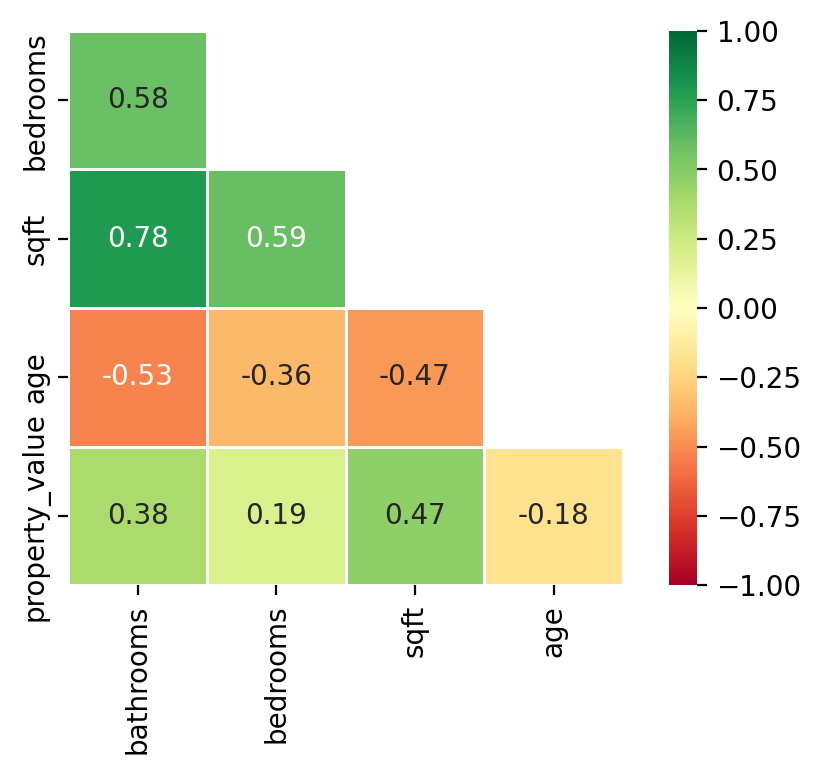

In [12]:
plt.figure(figsize=(len(train.columns), len(train.columns) * .6))

mask = np.triu(np.ones_like(train.corr().iloc[1:,:-1]),k=1)
sns.heatmap(train.corr().iloc[1:,:-1], mask=mask, linewidths=.5, annot=True,
                     cmap='RdYlGn', vmin=-1, vmax=1, square=True)

/var/folders/hg/jdcrdn3s5s3ddyrj47p9s7lh0000gn/T/ipykernel_18028/925584279.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr()['property_value'].sort_values(ascending=False).to_frame(),


<Axes: >

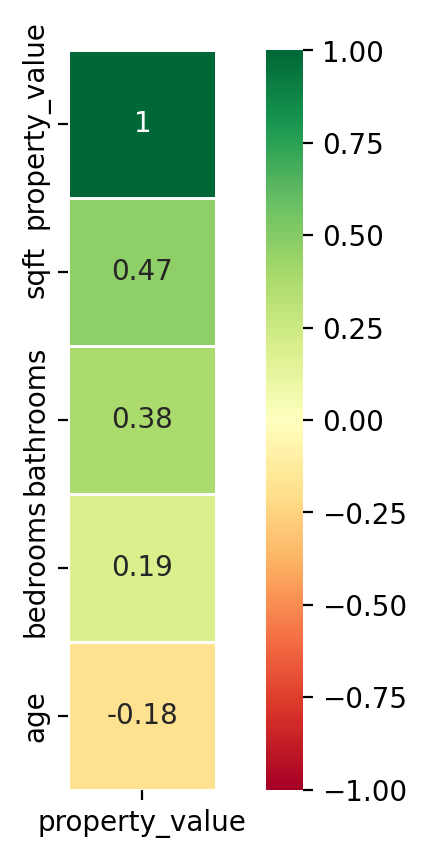

In [13]:
sns.heatmap(train.corr()['property_value'].sort_values(ascending=False).to_frame(),
            linewidths=.5, annot=True, cmap='RdYlGn',
            vmin=-1, vmax=1, square=True)

In [14]:
def explore_bivariate_cont_to_cont_target(df, target, cont_cols=None):
    '''
    Explores categorical feature relationships to continuous target
    '''
    if cont_cols == None:
        cont_cols = get_cat_and_cont_cols(df)[1]
    
    sns.pairplot(data=df[cont_cols], kind='reg', corner=True,
                 plot_kws={'scatter_kws':{'s':1, 'alpha':.5},
                           'line_kws':{'linewidth':1, 'alpha':.5, 'color':'red'}})
    plt.show()
    
    plt.figure(figsize=(len(train.columns), len(train.columns) * .6))

    mask = np.triu(np.ones_like(df.corr().iloc[1:,:-1]),k=1)
    sns.heatmap(df.corr().iloc[1:,:-1], mask=mask, linewidths=.5, annot=True,
                         cmap='RdYlGn', vmin=-1, vmax=1, square=True)
    plt.show()
    
    sns.heatmap(df.corr()[target].sort_values(ascending=False).to_frame(),
            linewidths=.5, annot=True, cmap='RdYlGn',
            vmin=-1, vmax=1, square=True)
    plt.show()

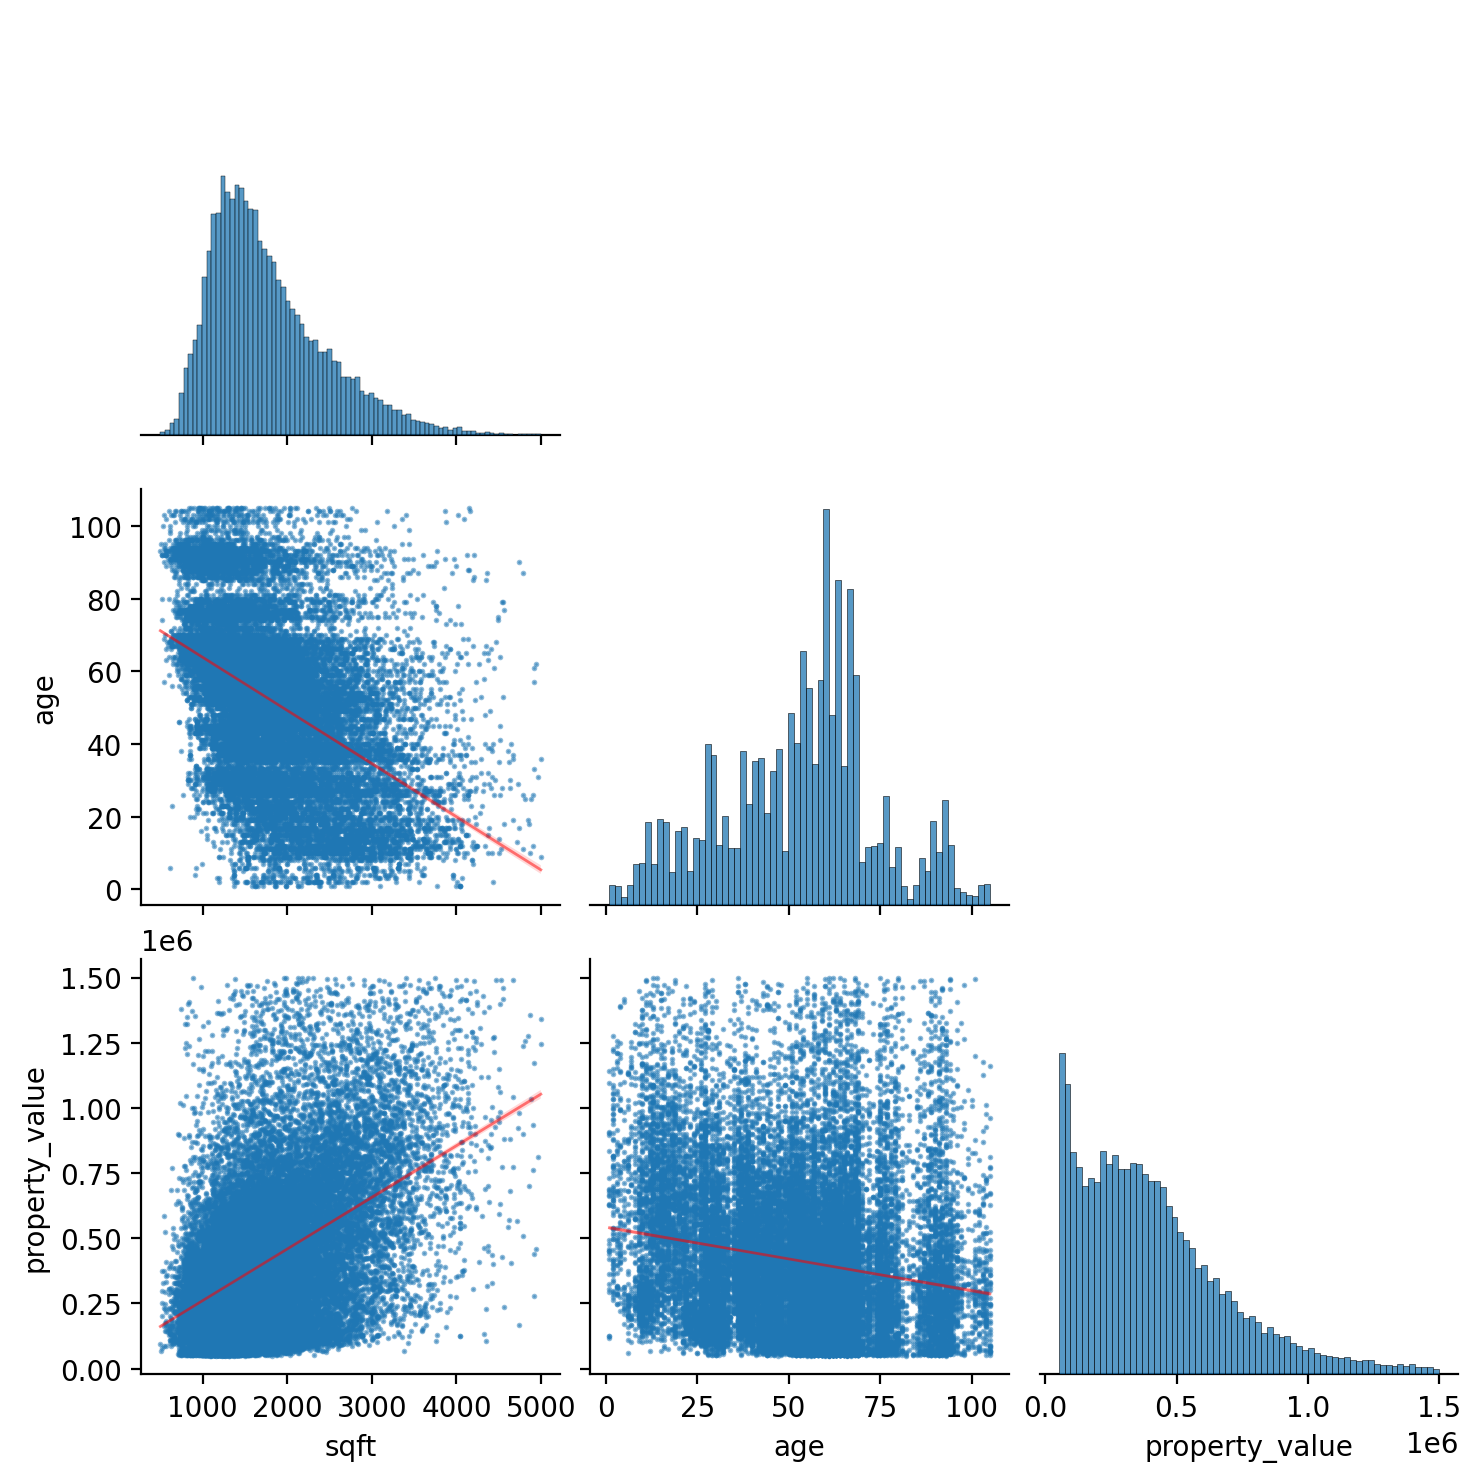

/var/folders/hg/jdcrdn3s5s3ddyrj47p9s7lh0000gn/T/ipykernel_18028/1470874836.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.corr().iloc[1:,:-1]),k=1)
/var/folders/hg/jdcrdn3s5s3ddyrj47p9s7lh0000gn/T/ipykernel_18028/1470874836.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr().iloc[1:,:-1], mask=mask, linewidths=.5, annot=True,


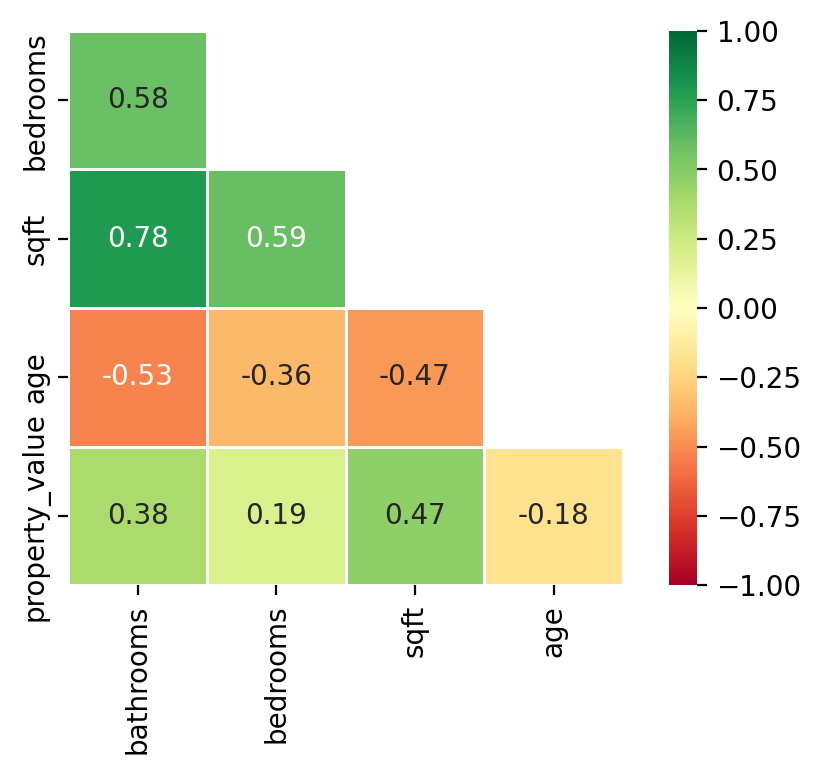

/var/folders/hg/jdcrdn3s5s3ddyrj47p9s7lh0000gn/T/ipykernel_18028/1470874836.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr()[target].sort_values(ascending=False).to_frame(),


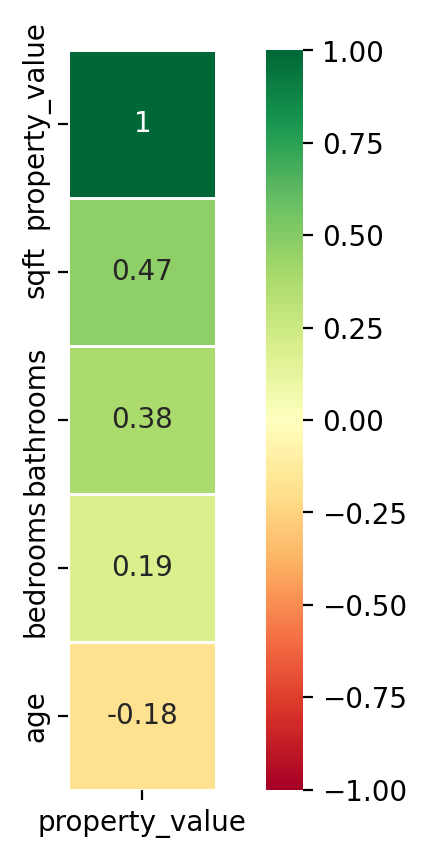

In [15]:
explore_bivariate_cont_to_cont_target(train, 'property_value', cont_cols=['sqft', 'age', 'property_value'])

Insights:
- sqft shows a strong relationship with property value
- bathrooms shows a moderate relationship, but it is strongly related to sqft

B.

In [16]:
cat_cols = ['bathrooms', 'bedrooms', 'county']
for col in cat_cols:
    display(train.groupby(col)['property_value'].describe().T)

bathrooms       1.00       1.50       2.00       2.50       3.00       3.50  \
count        5271.00     552.00   14578.00    2649.00    6780.00     499.00   
mean       299696.47  313413.88  353446.98  514635.76  519509.37  864760.43   
std        210972.36  175280.74  250232.19  244036.64  301000.49  308995.77   
min         50270.00   50516.00   50067.00   51614.00   52759.00   94107.00   
25%        151244.00  195012.50  153566.75  344422.00  280635.00  666929.00   
50%        261397.00  312590.00  311972.00  503583.00  478442.00  864750.00   
75%        390000.00  420000.00  477237.50  667919.00  705390.25 1088708.50   
max       1493861.00 1270326.00 1500000.00 1483677.00 1500000.00 1500000.00   

bathrooms       4.00  
count        1066.00  
mean       745643.77  
std        351642.28  
min         97640.00  
25%        471968.00  
50%        732490.00  
75%       1015310.50  
max       1500000.00

bedrooms          2          3          4          5
count       5098.00   15014.00    9466.00    1817.00
mean      349268.41  384986.85  472191.52  543006.12
std       250942.73  269587.53  303123.68  320177.80
min        50071.00   50067.00   50068.00   50272.00
25%       169925.75  179051.75  236098.50  299274.00
50%       292000.00  338470.00  423769.00  501370.00
75%       451719.75  513222.75  649931.75  740050.00
max      1493861.00 1500000.00 1500000.00 1490000.00

county         LA     Orange    Ventura
count    20117.00    8513.00    2765.00
mean    380198.96  481781.73  458336.24
std     282446.22  290397.28  250969.37
min      50067.00   50091.00   50640.00
25%     168903.00  269116.00  292260.00
50%     311846.00  445088.00  435323.00
75%     503100.00  654567.00  583568.00
max    1500000.00 1499208.00 1500000.00

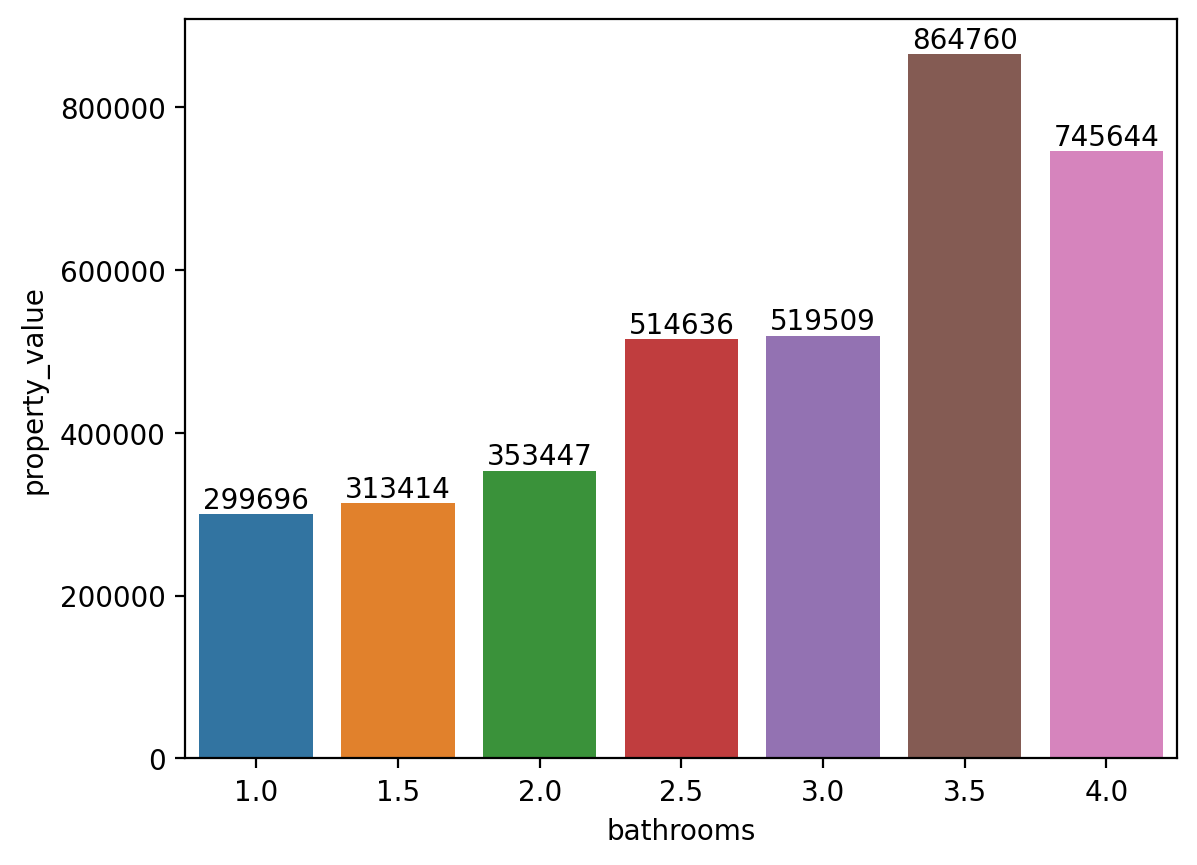

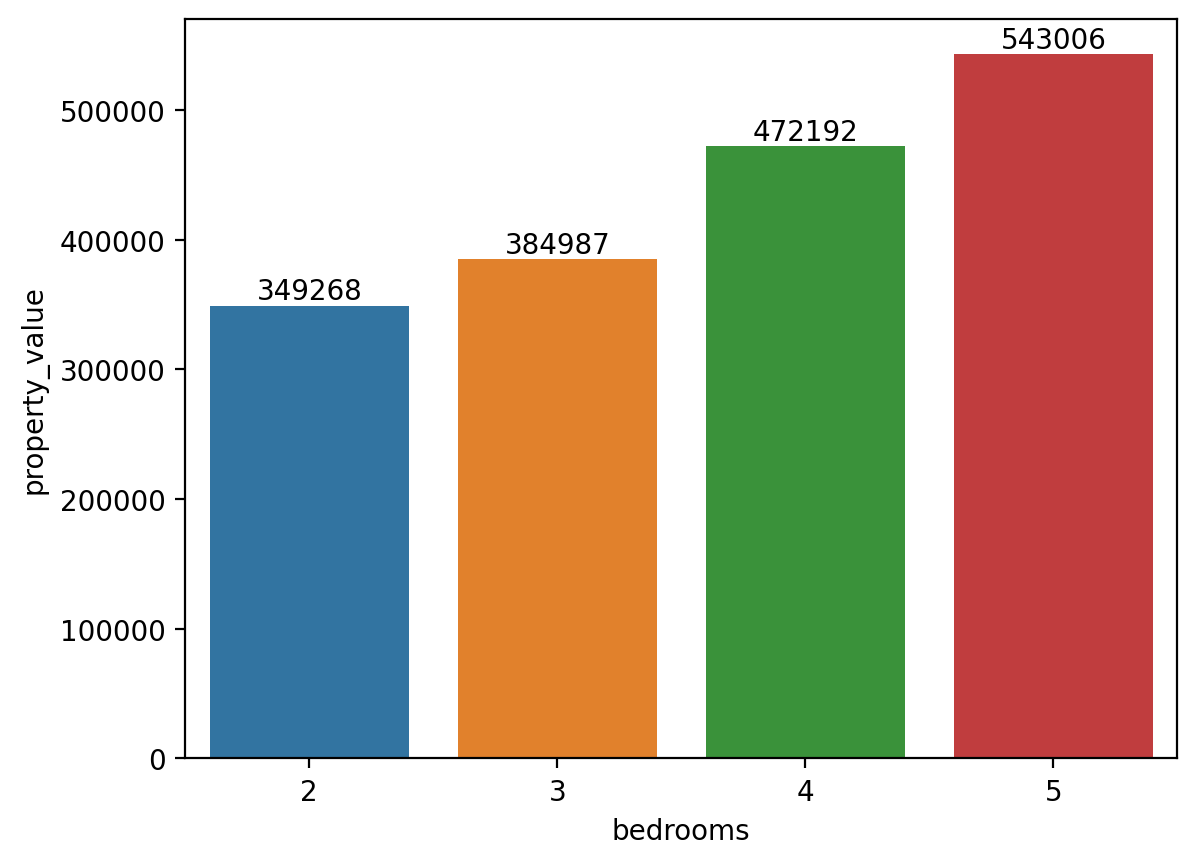

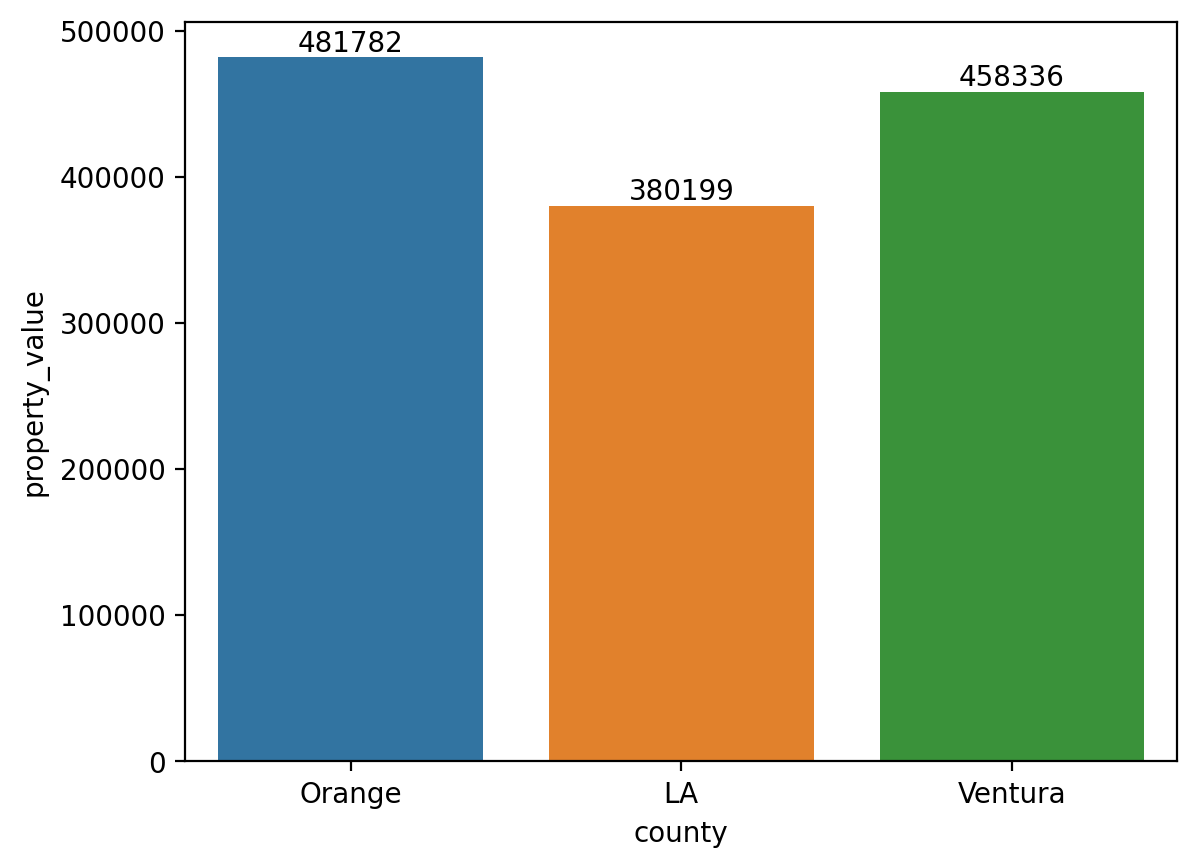

In [17]:
for col in cat_cols:
    sns.barplot(data=train, x=col, y='property_value', errorbar=None)
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{round(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom')
    plt.show()

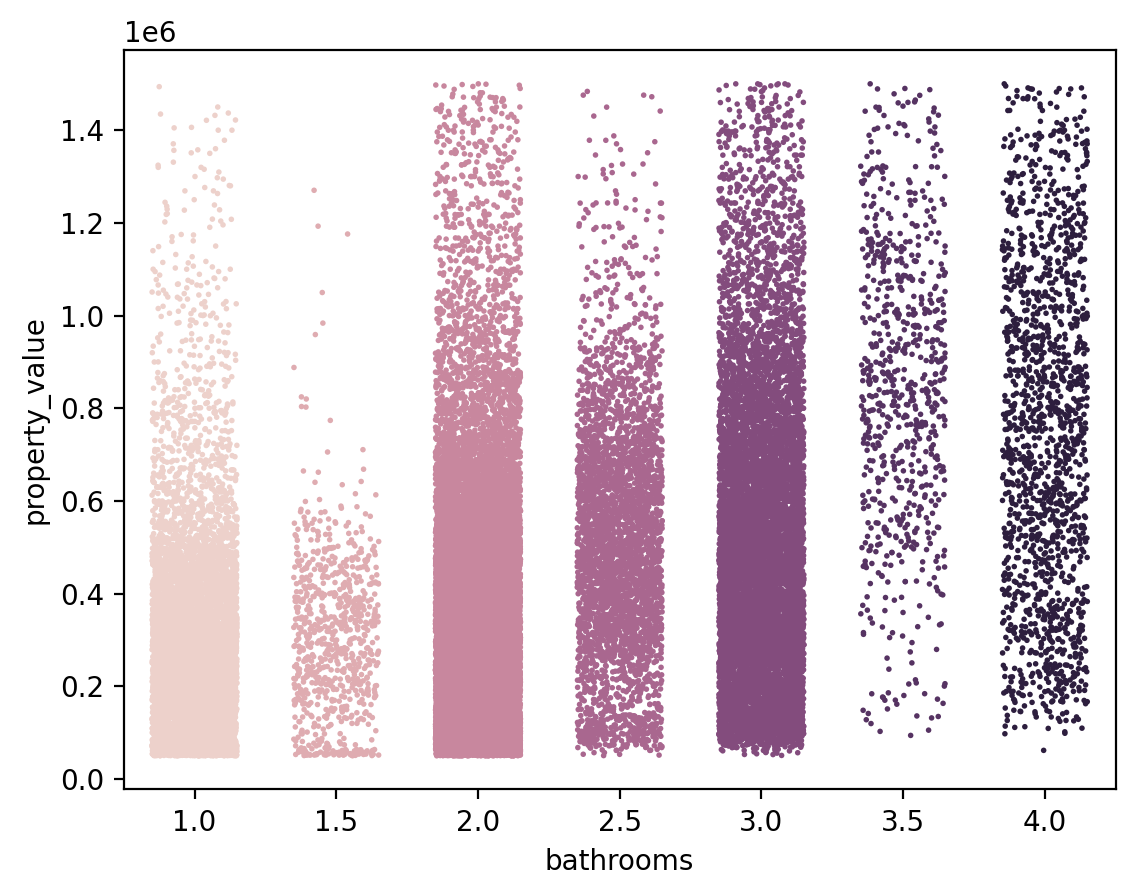

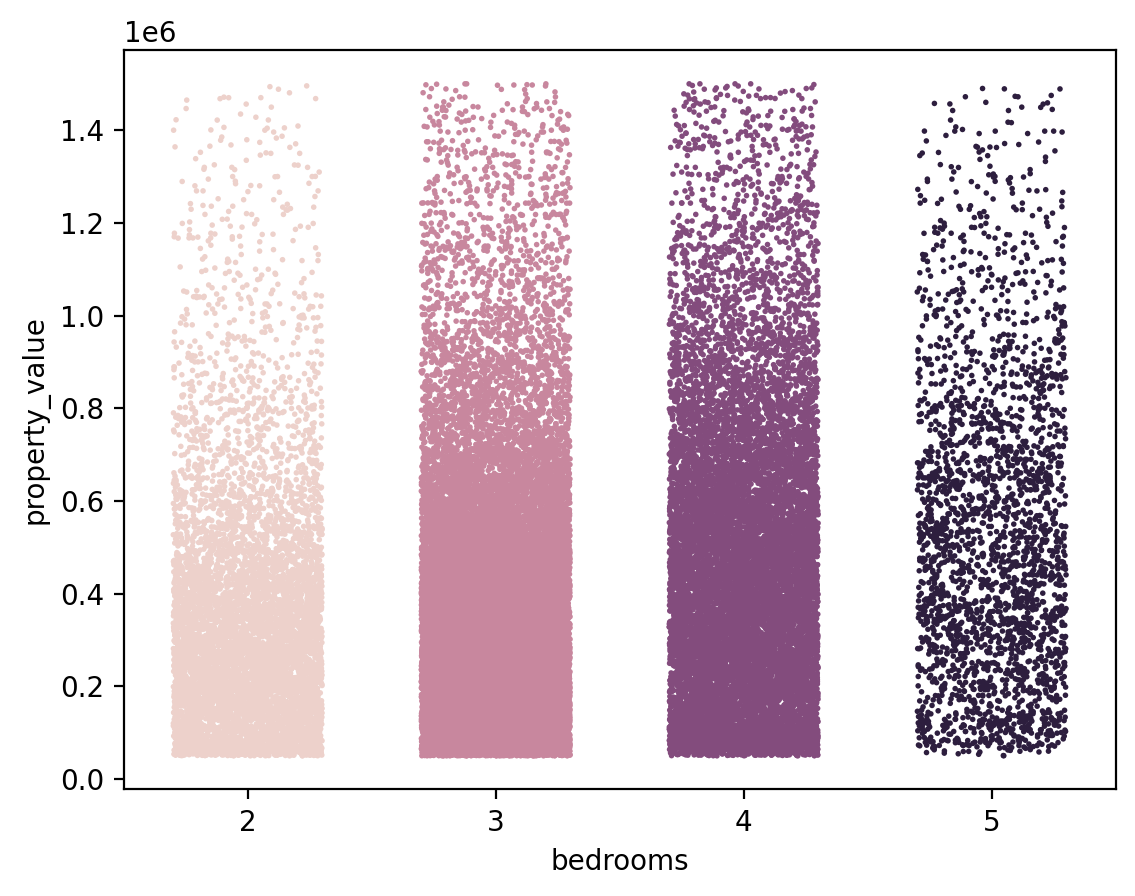

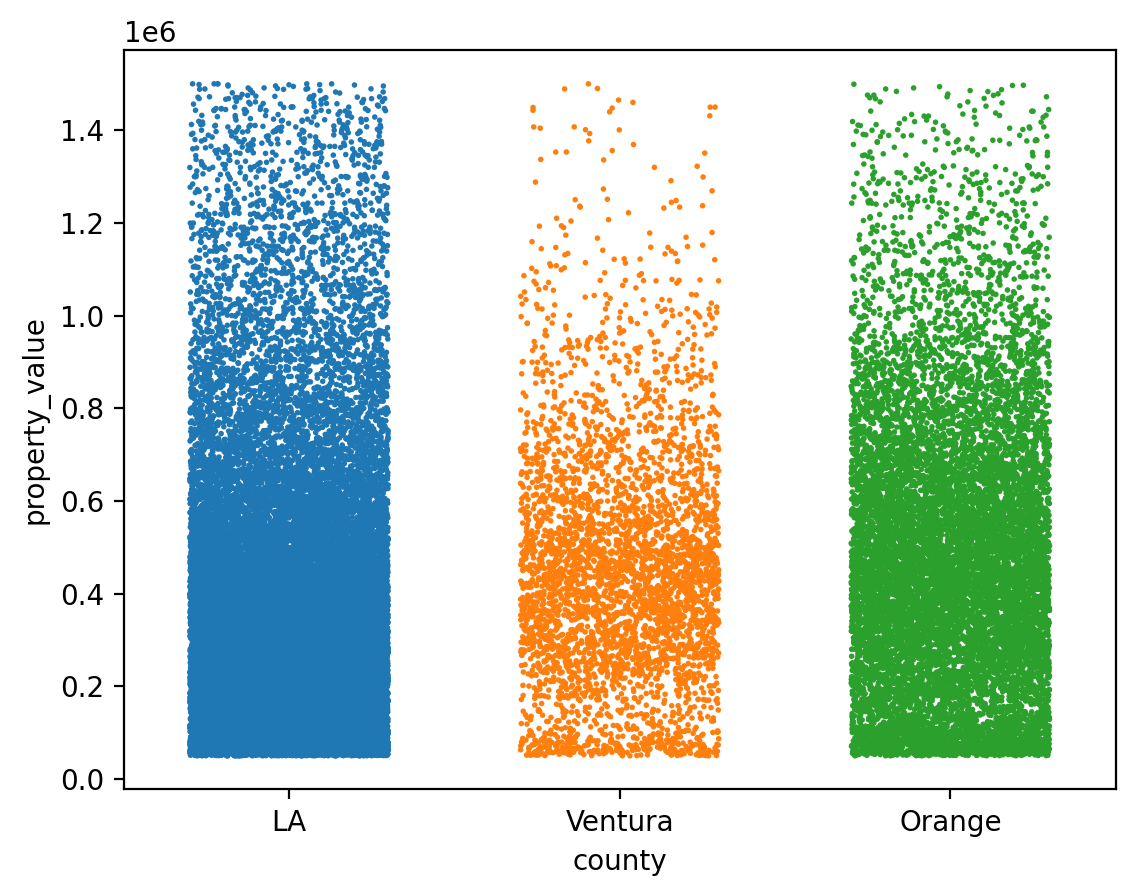

In [18]:
for col in cat_cols:
    sns.stripplot(data=df, x=col, y='property_value', hue=col, jitter=.3,
              size=2, legend=False)
    plt.show()

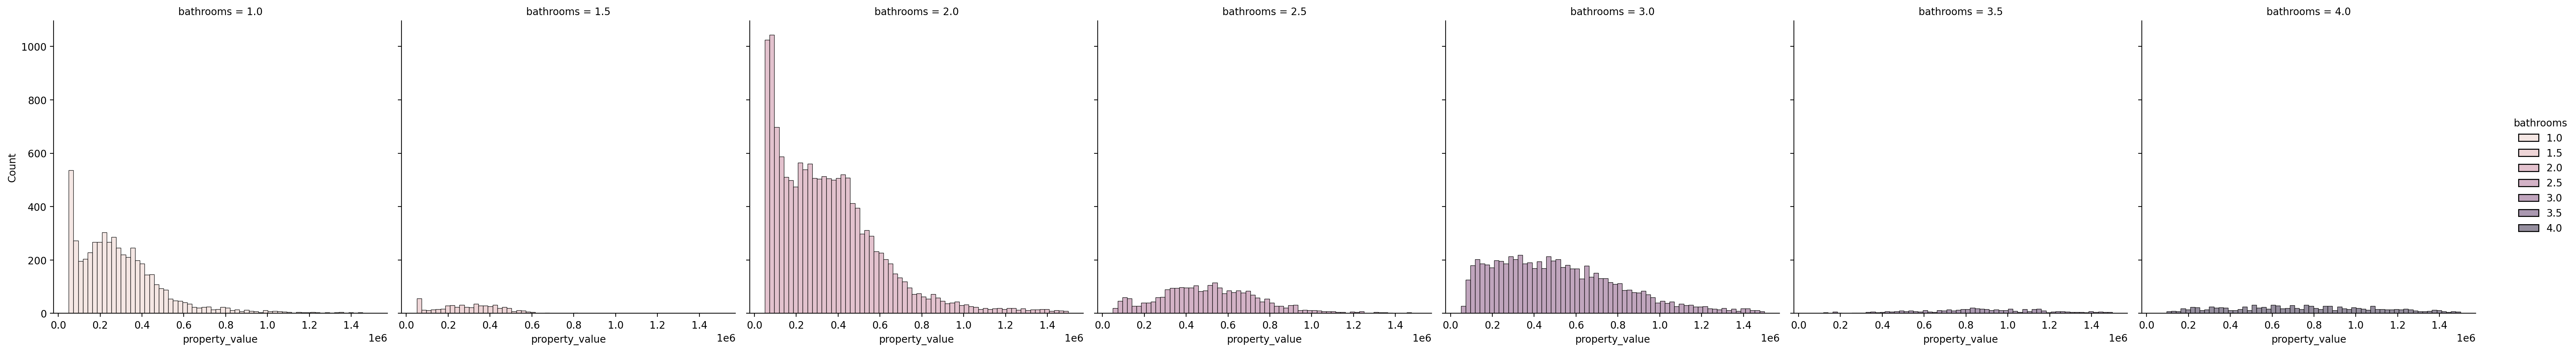

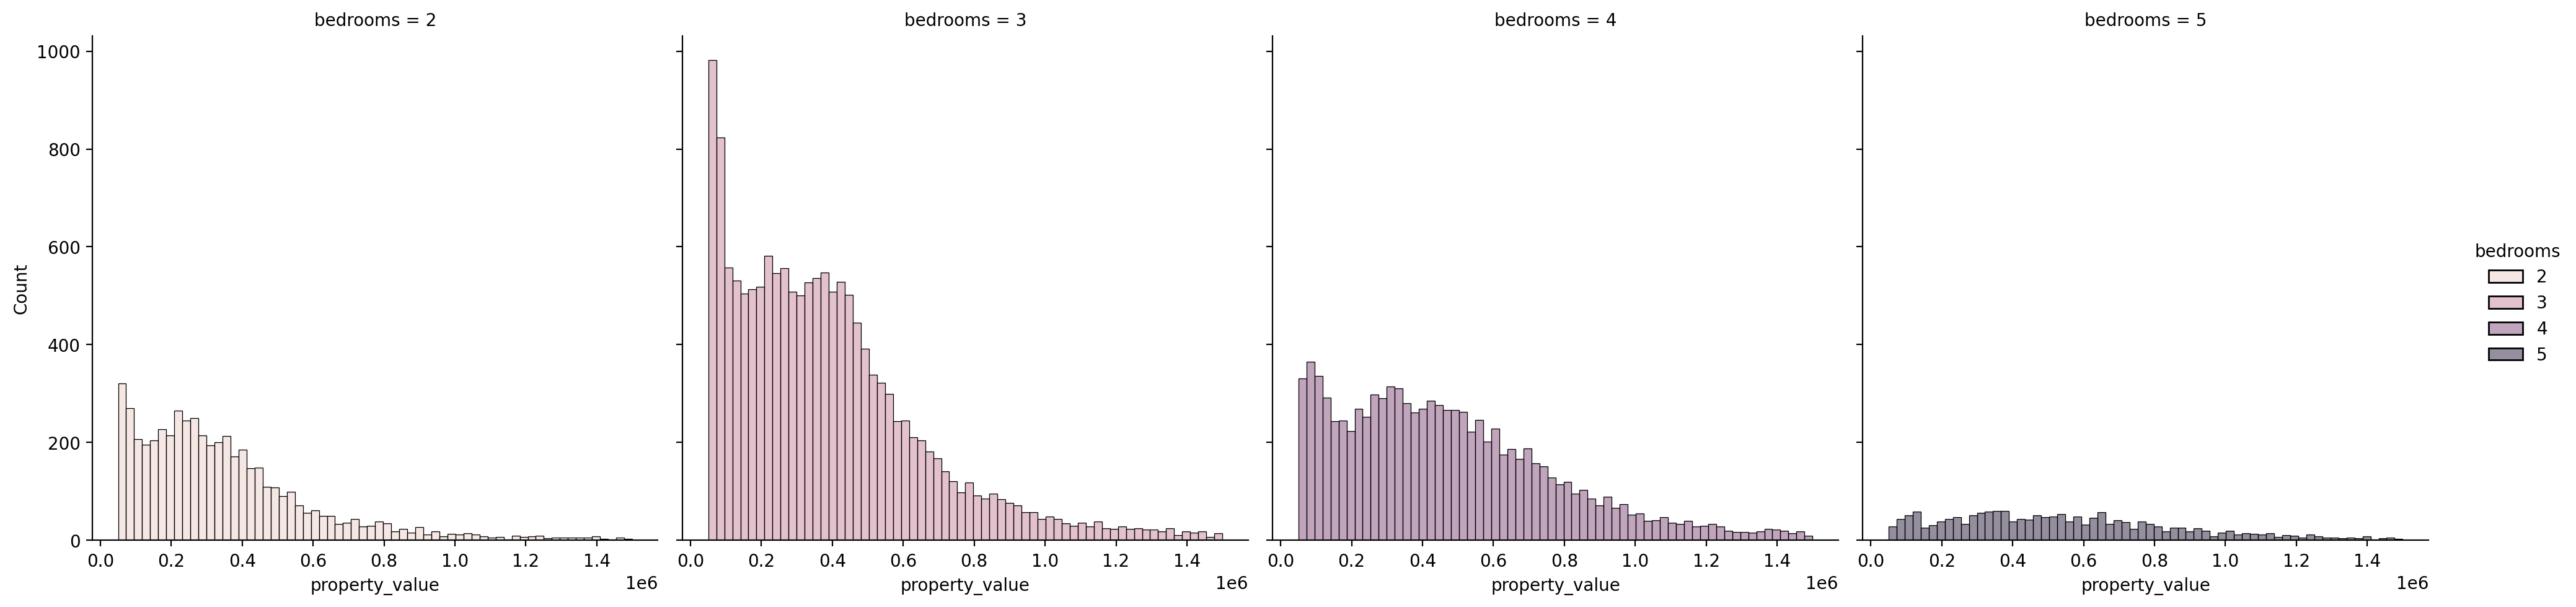

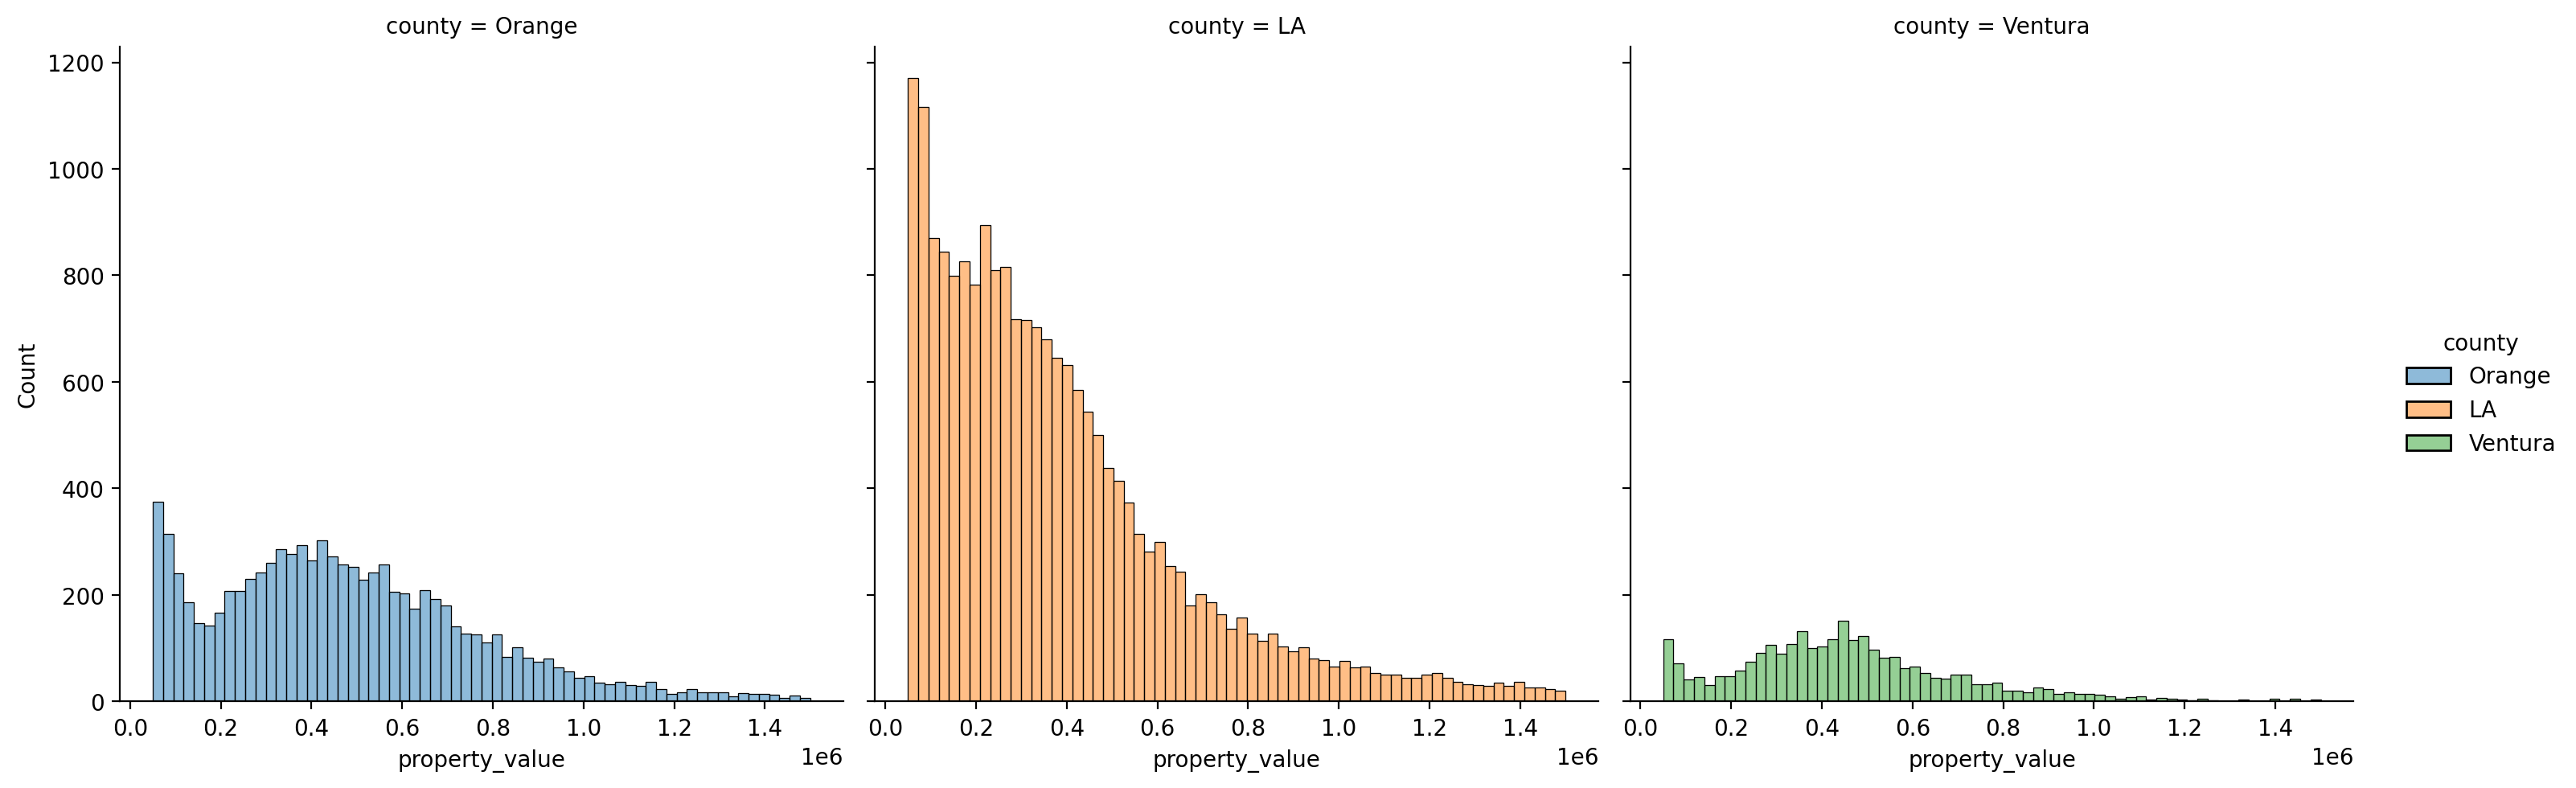

In [19]:
for col in cat_cols:
    sns.displot(col=col, x='property_value', data=train, hue=col)
    plt.show()

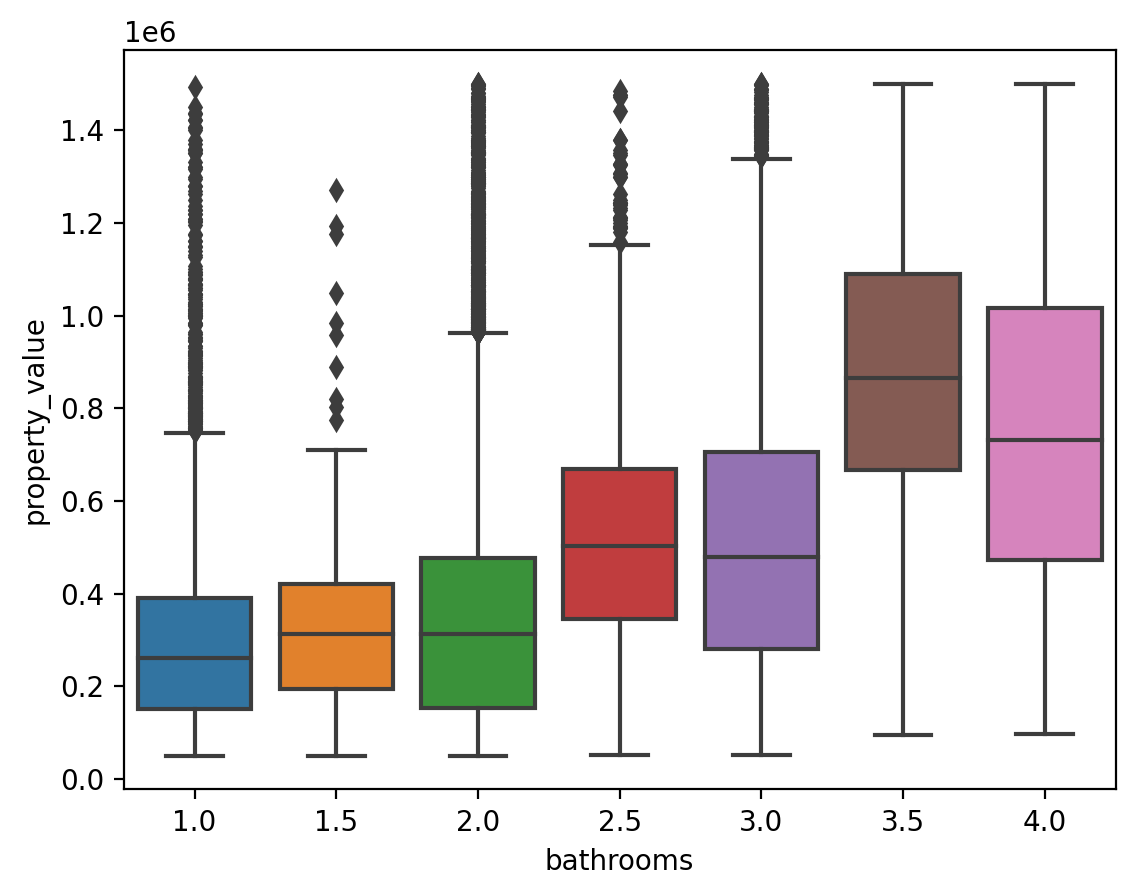

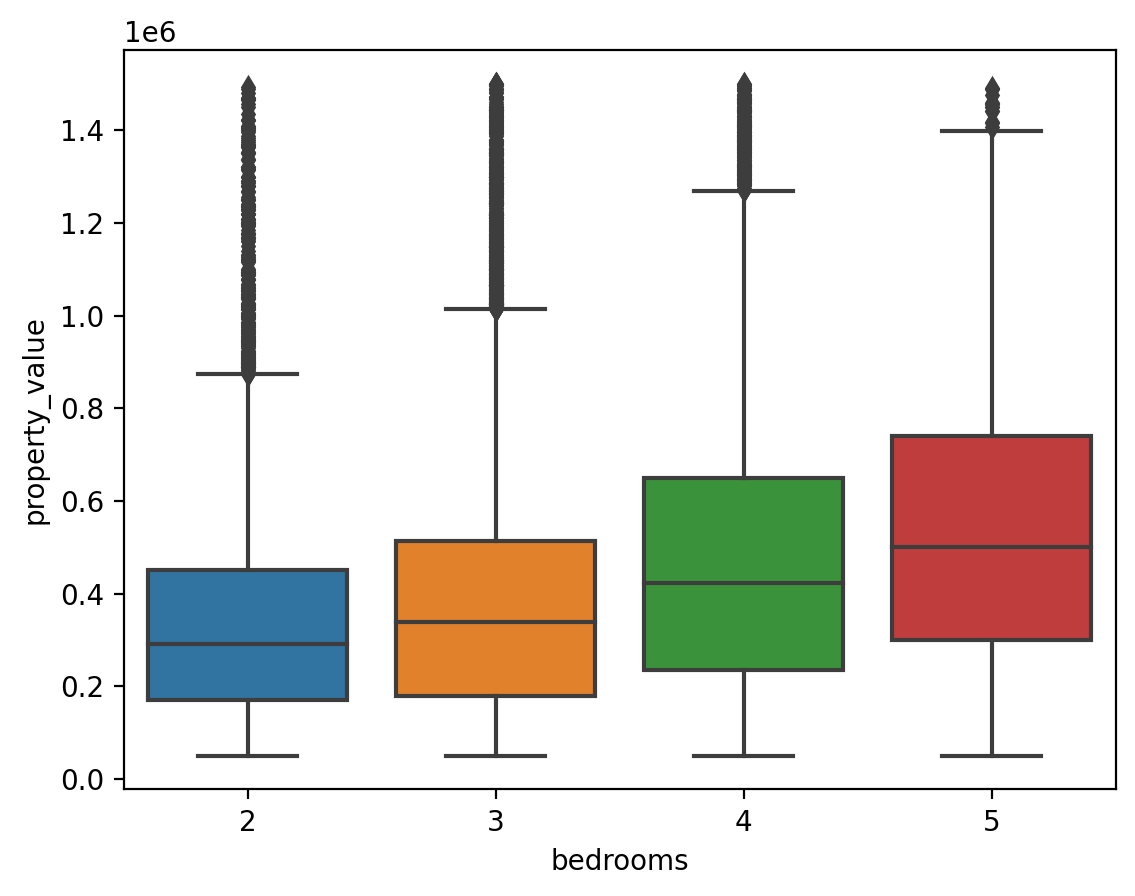

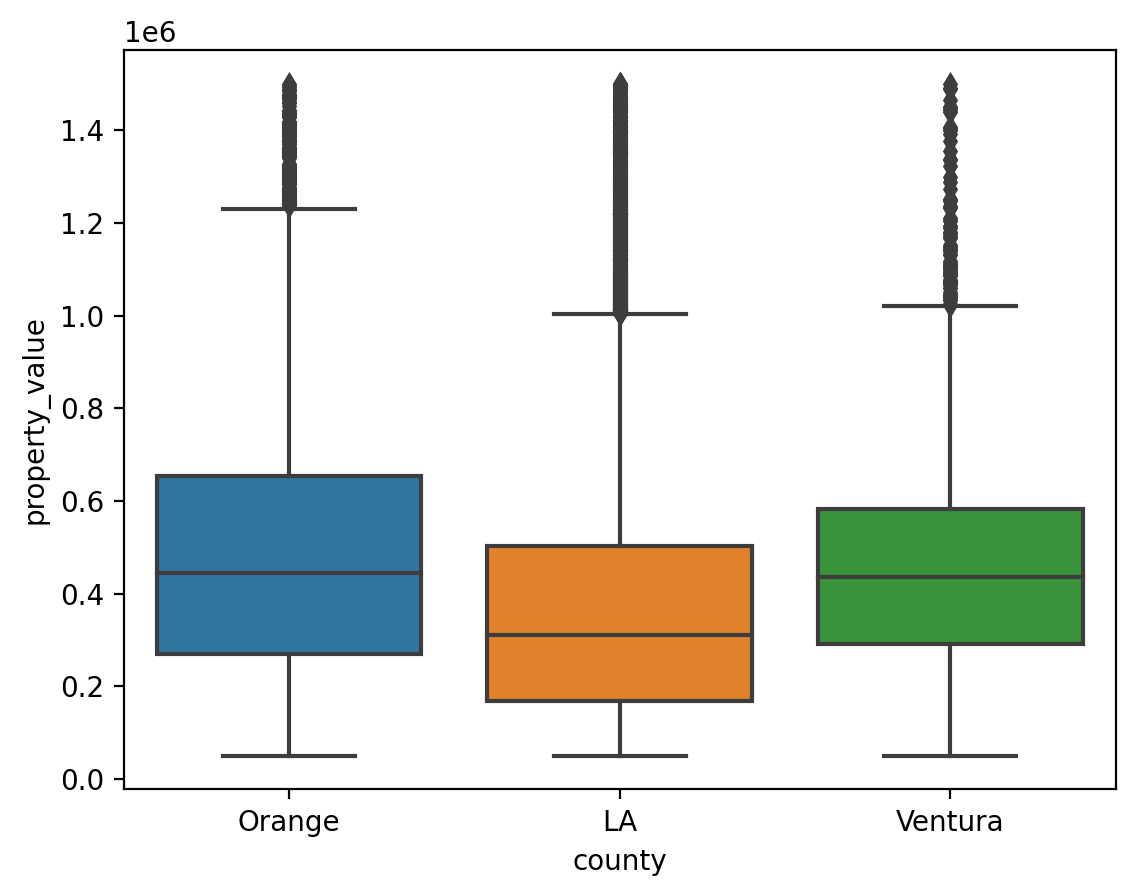

In [20]:
for col in cat_cols:
    sns.boxplot(x=col, y='property_value', data=train)
    plt.show()

In [21]:
def explore_bivariate_cat_to_cont_target(df, target, cat_cols=None):
    '''
    Explores categorical feature relationships to continuous target
    Provides descriptive stats for each feature category
    '''
#     if cat_cols == None:
#         cat_cols = get_cat_and_cont_cols(df)[0]
        
    for col in cat_cols:
        print(f'{col} group {target} stats')
        display(df.groupby(col)[target].describe().T)
        
        plot_bivariate_cat_to_cont_target_charts(df, target, col)
        

def plot_bivariate_cat_to_cont_target_charts(df, target, col):
    print(f'{col} group {target} averages')
    sns.barplot(data=df, x=col, y=target, errorbar=None)
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{round(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom')
    plt.show()

    print(f'{col} group {target} distributions')
    sns.displot(data=df, x=target, col=col, hue=col)
    plt.show()
    sns.stripplot(data=df, x=col, y=target, hue=col, jitter=.3,
                  size=1.5, legend=False)
    plt.show()

    print(f'{col} group {target} boxplots')
    sns.boxplot(data=df, x=col, y=target)
    plt.show()

bathrooms group property_value stats


bathrooms       1.00       1.50       2.00       2.50       3.00       3.50  \
count        5271.00     552.00   14578.00    2649.00    6780.00     499.00   
mean       299696.47  313413.88  353446.98  514635.76  519509.37  864760.43   
std        210972.36  175280.74  250232.19  244036.64  301000.49  308995.77   
min         50270.00   50516.00   50067.00   51614.00   52759.00   94107.00   
25%        151244.00  195012.50  153566.75  344422.00  280635.00  666929.00   
50%        261397.00  312590.00  311972.00  503583.00  478442.00  864750.00   
75%        390000.00  420000.00  477237.50  667919.00  705390.25 1088708.50   
max       1493861.00 1270326.00 1500000.00 1483677.00 1500000.00 1500000.00   

bathrooms       4.00  
count        1066.00  
mean       745643.77  
std        351642.28  
min         97640.00  
25%        471968.00  
50%        732490.00  
75%       1015310.50  
max       1500000.00

bathrooms group property_value averages


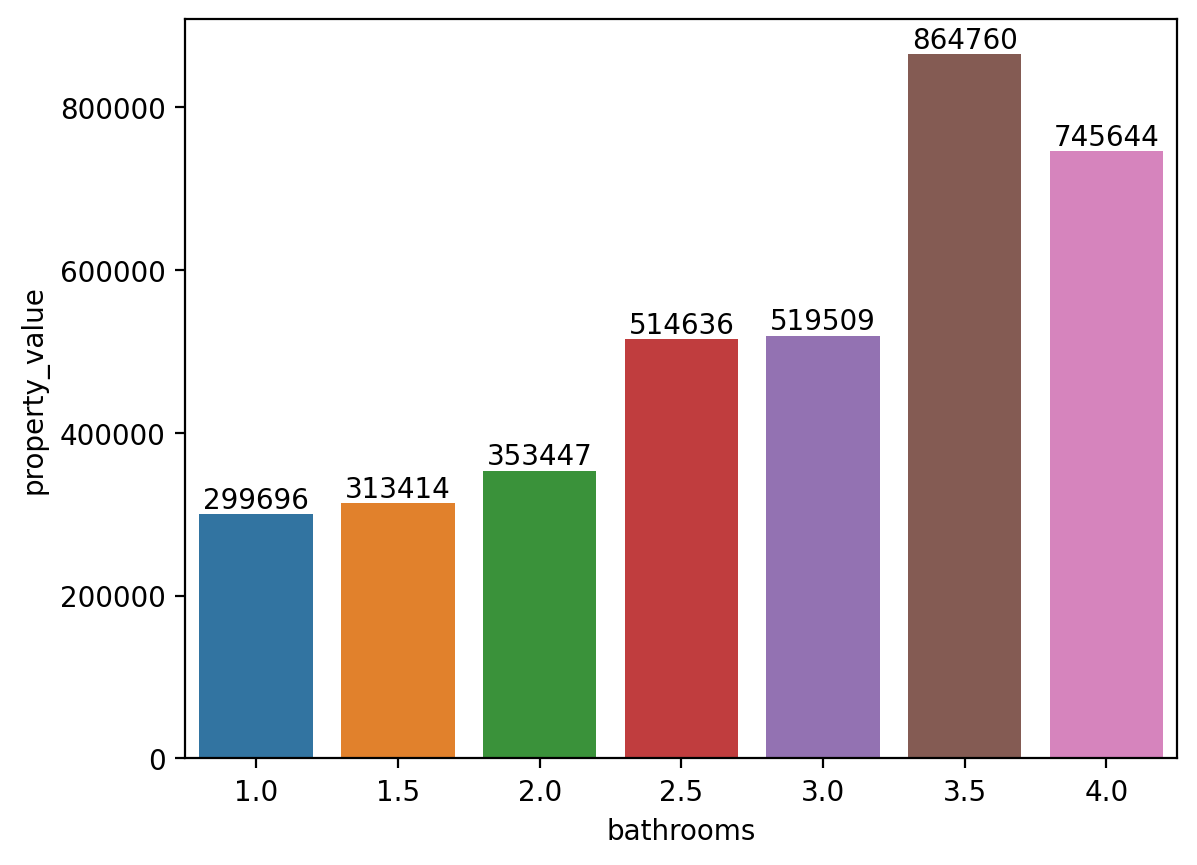

bathrooms group property_value distributions


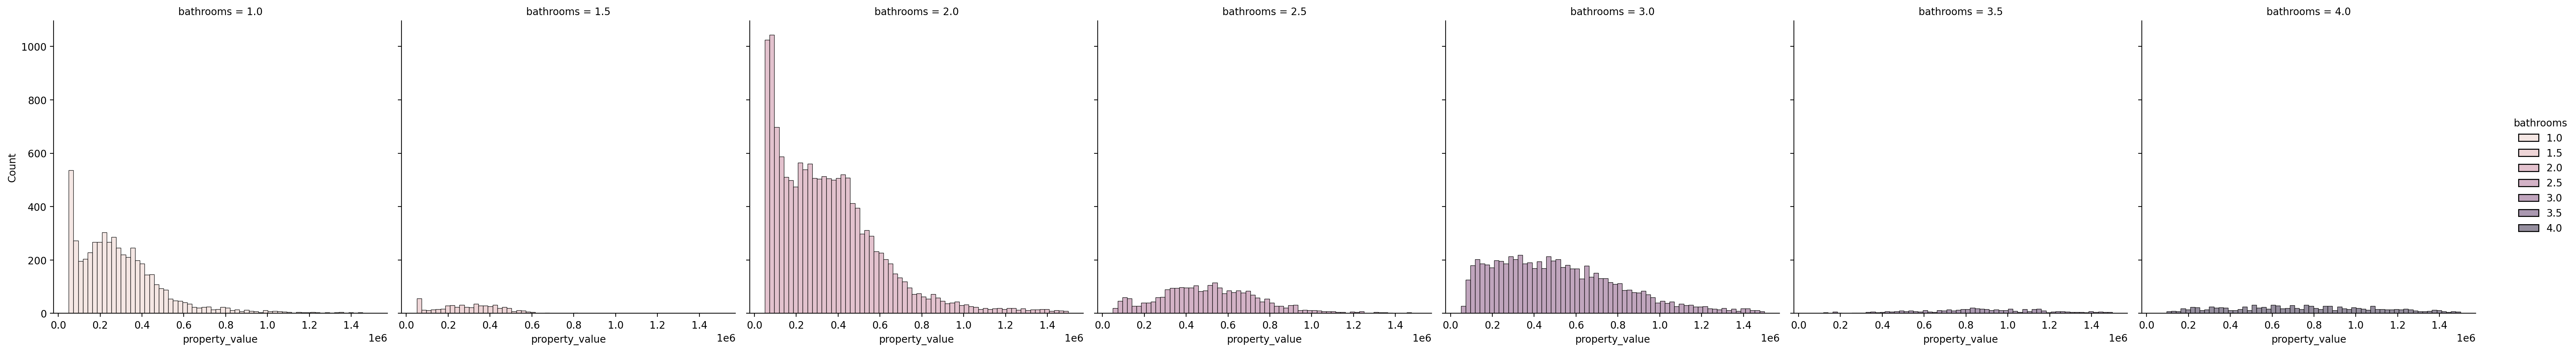

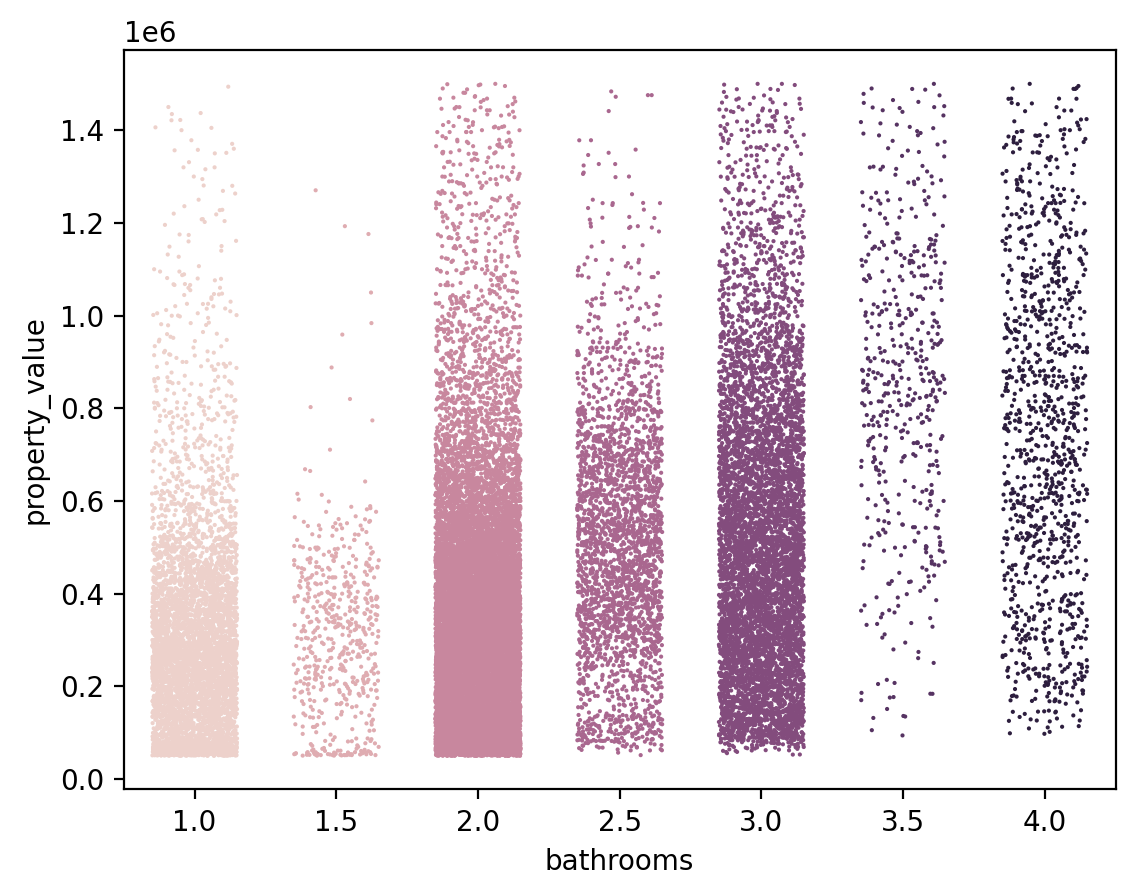

bathrooms group property_value boxplots


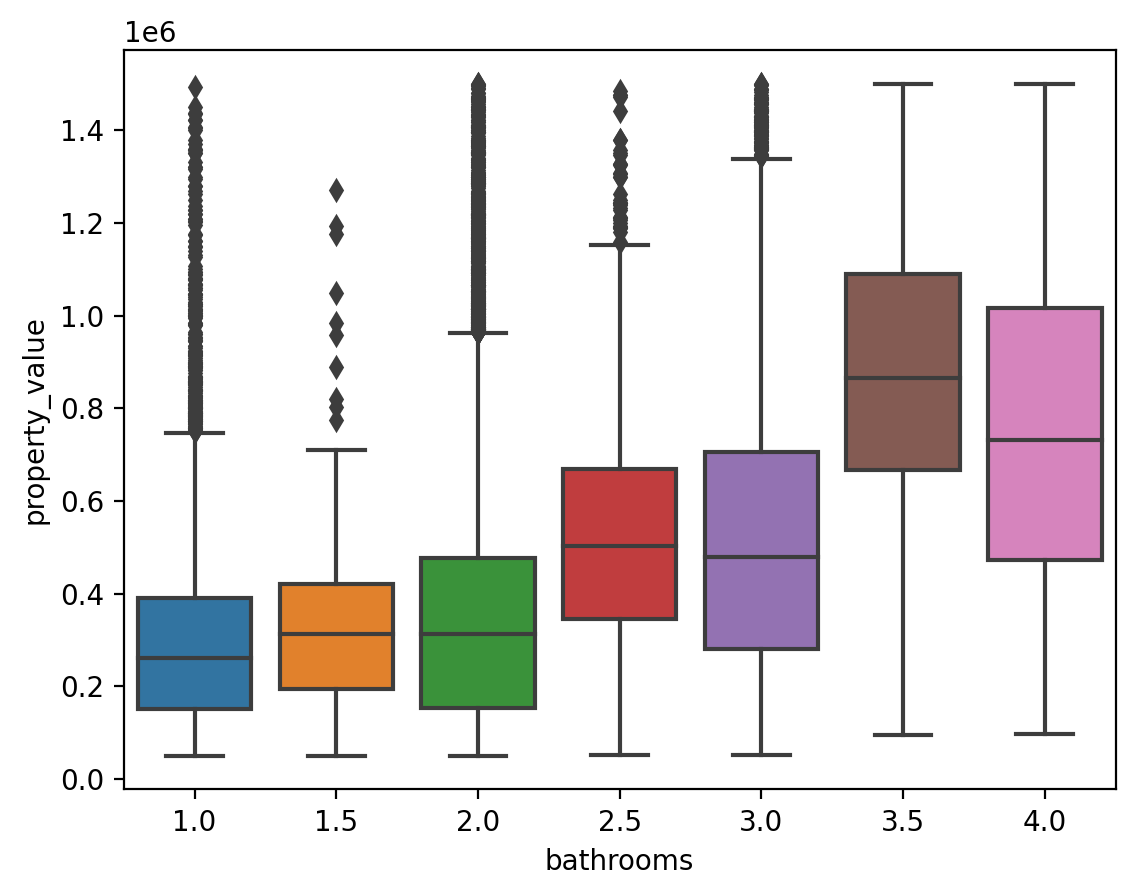

bedrooms group property_value stats


bedrooms          2          3          4          5
count       5098.00   15014.00    9466.00    1817.00
mean      349268.41  384986.85  472191.52  543006.12
std       250942.73  269587.53  303123.68  320177.80
min        50071.00   50067.00   50068.00   50272.00
25%       169925.75  179051.75  236098.50  299274.00
50%       292000.00  338470.00  423769.00  501370.00
75%       451719.75  513222.75  649931.75  740050.00
max      1493861.00 1500000.00 1500000.00 1490000.00

bedrooms group property_value averages


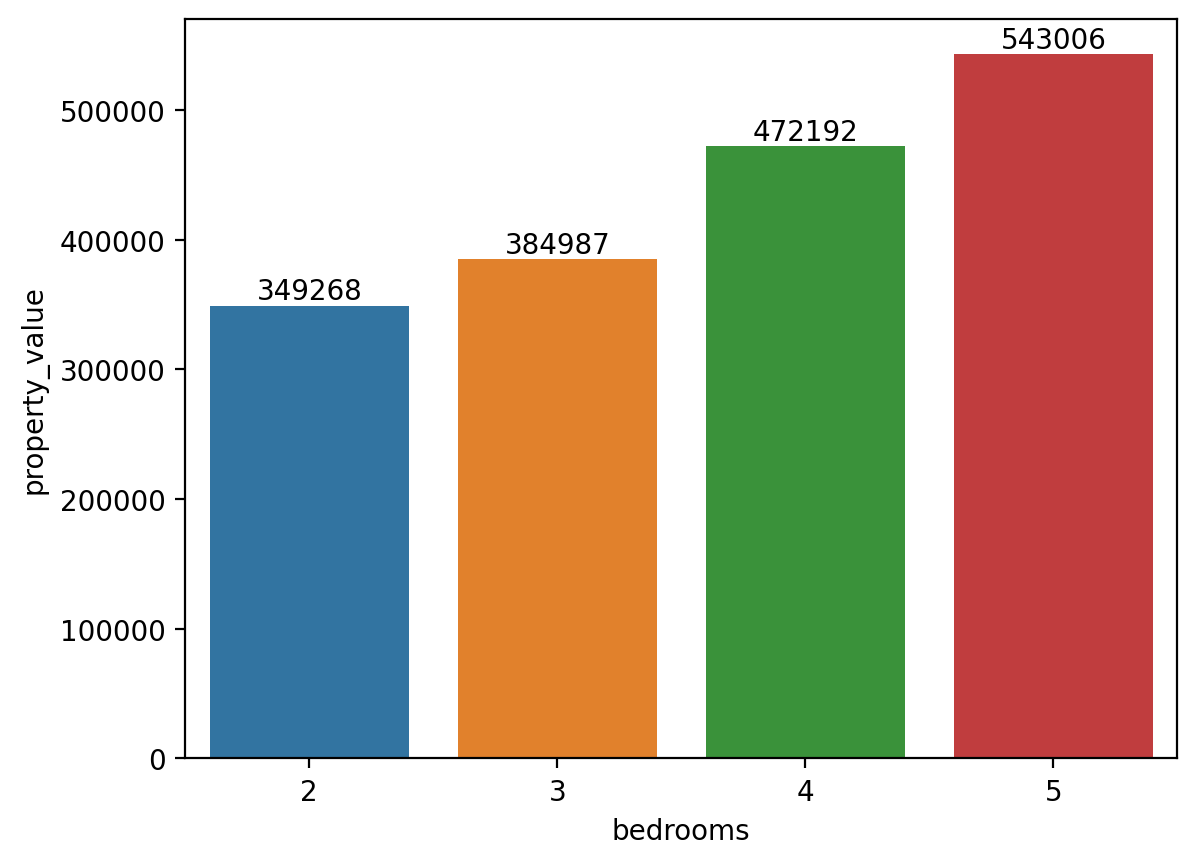

bedrooms group property_value distributions


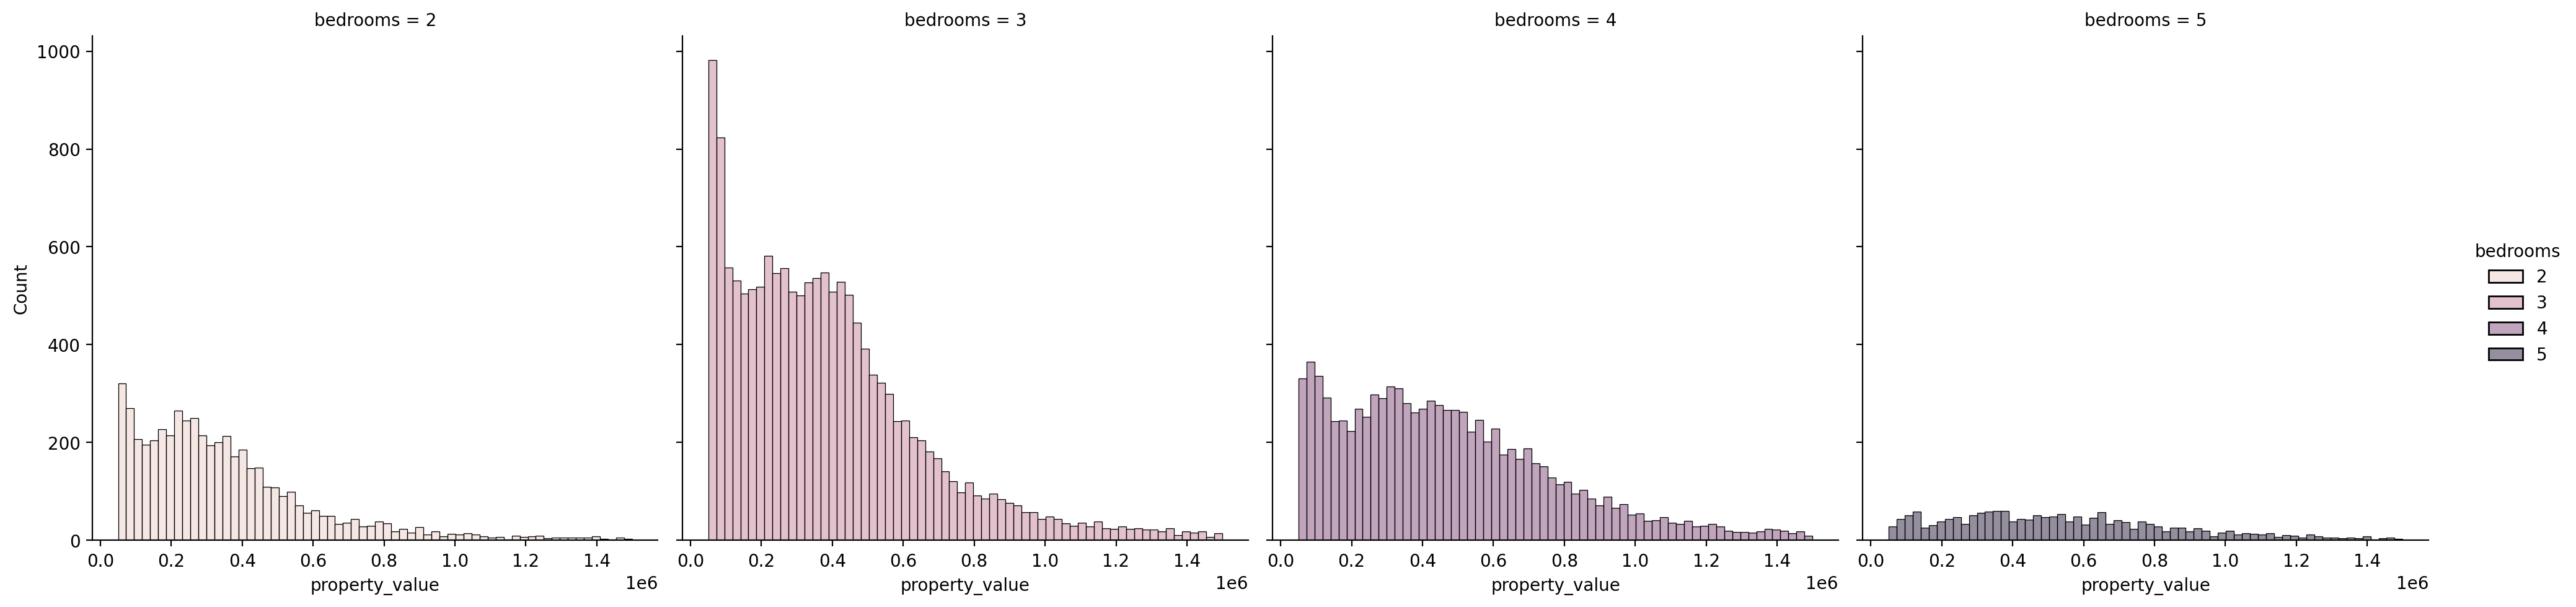

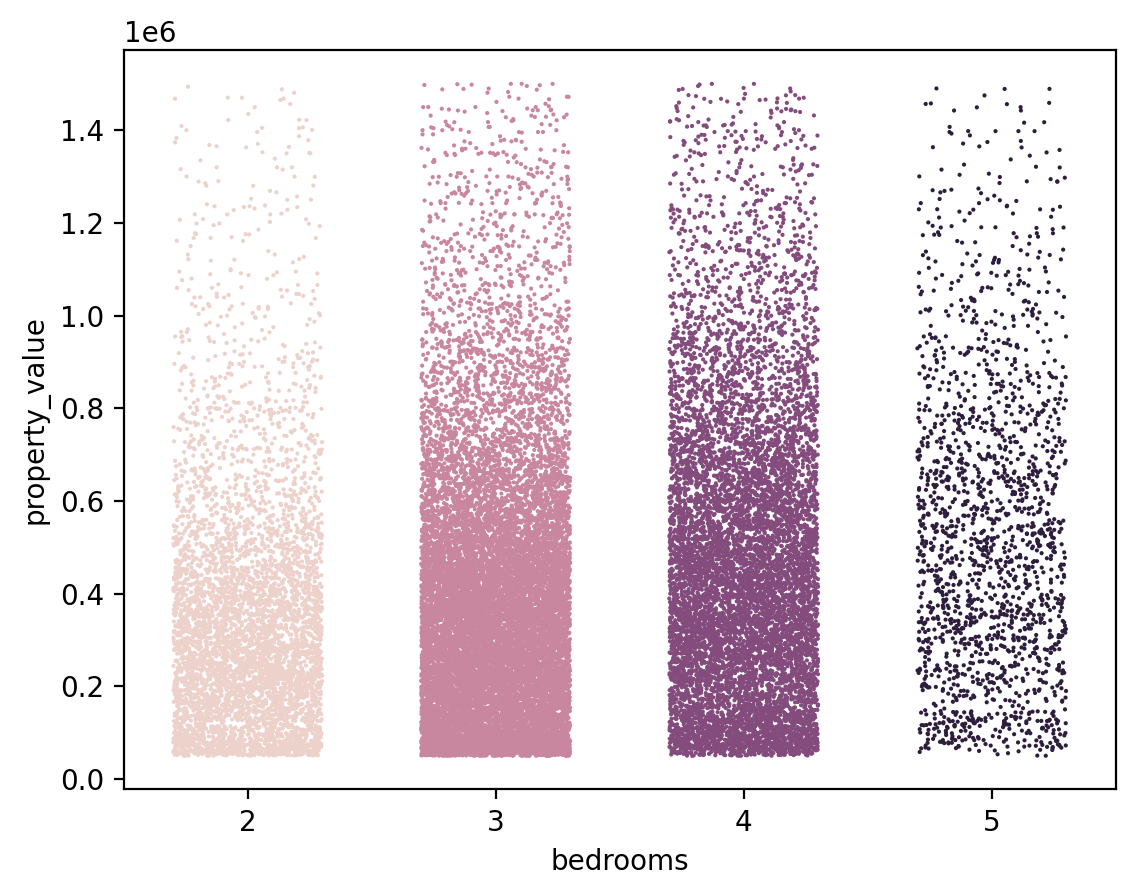

bedrooms group property_value boxplots


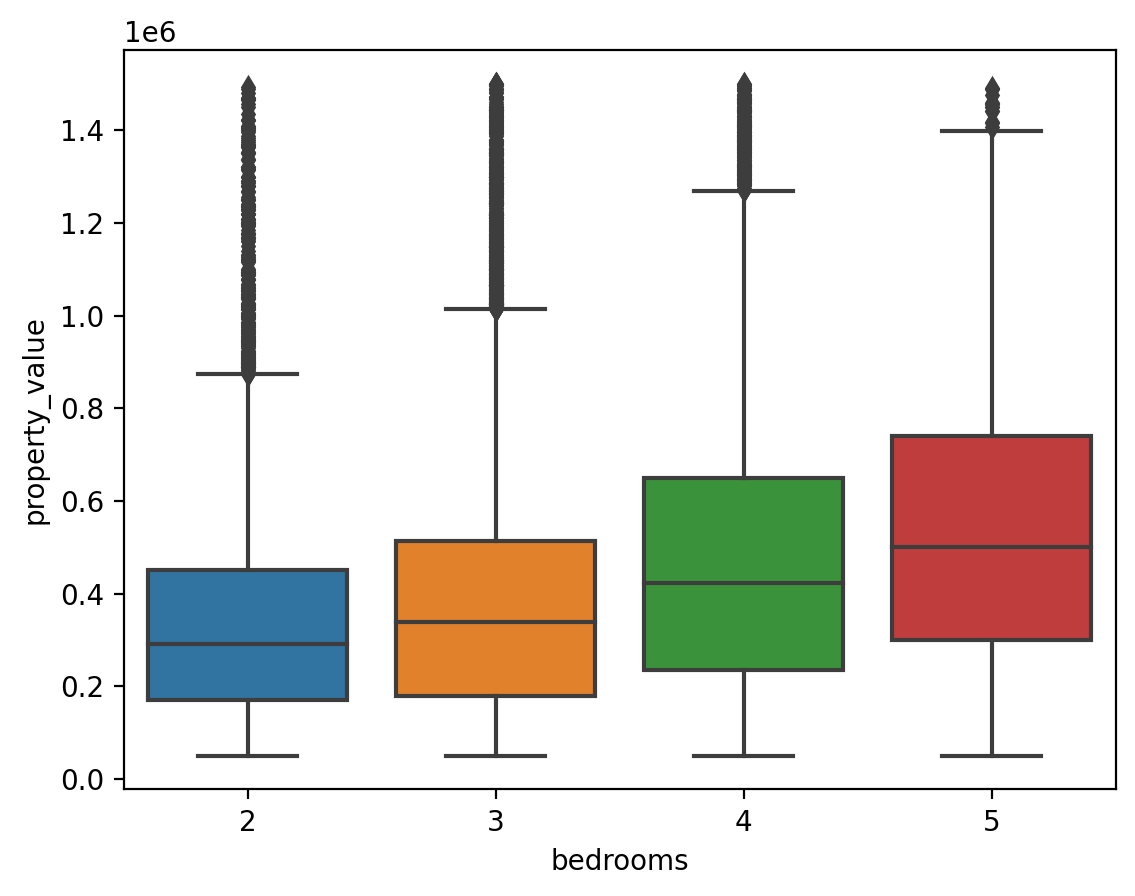

county group property_value stats


county         LA     Orange    Ventura
count    20117.00    8513.00    2765.00
mean    380198.96  481781.73  458336.24
std     282446.22  290397.28  250969.37
min      50067.00   50091.00   50640.00
25%     168903.00  269116.00  292260.00
50%     311846.00  445088.00  435323.00
75%     503100.00  654567.00  583568.00
max    1500000.00 1499208.00 1500000.00

county group property_value averages


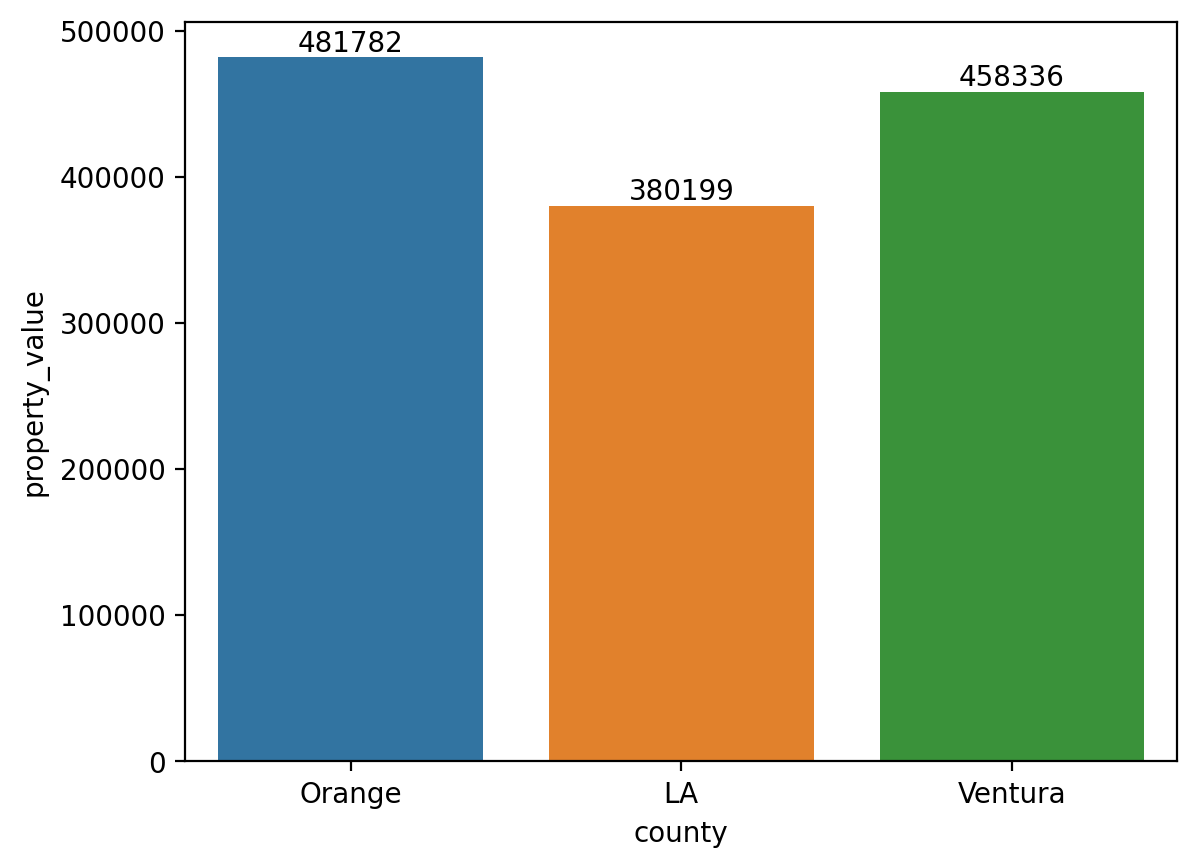

county group property_value distributions


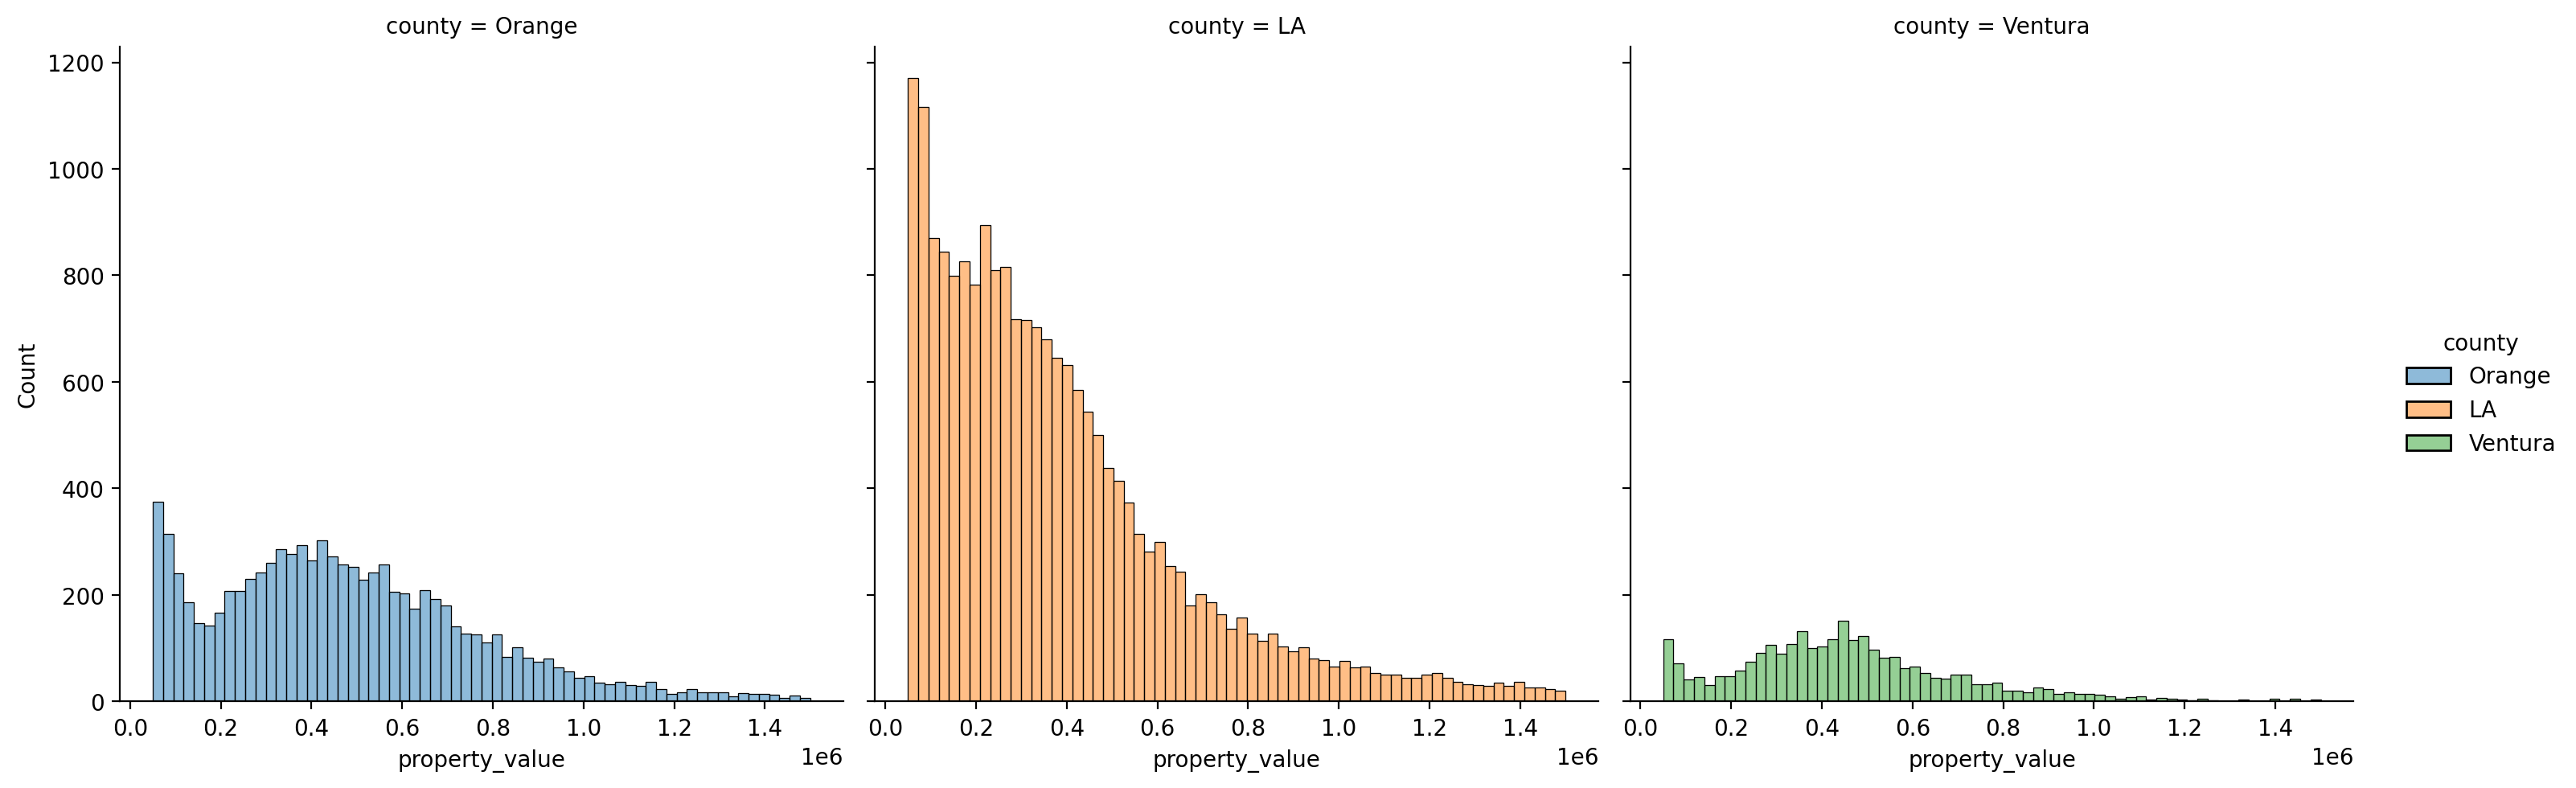

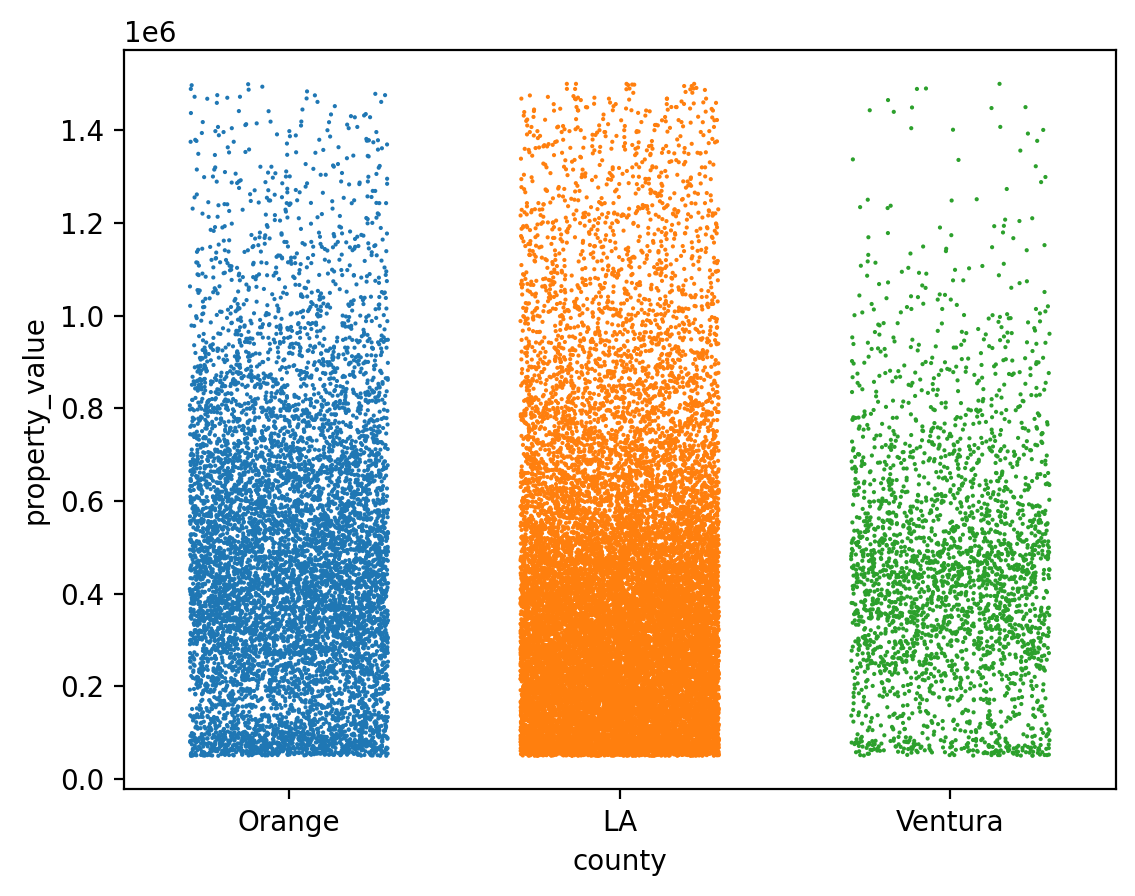

county group property_value boxplots


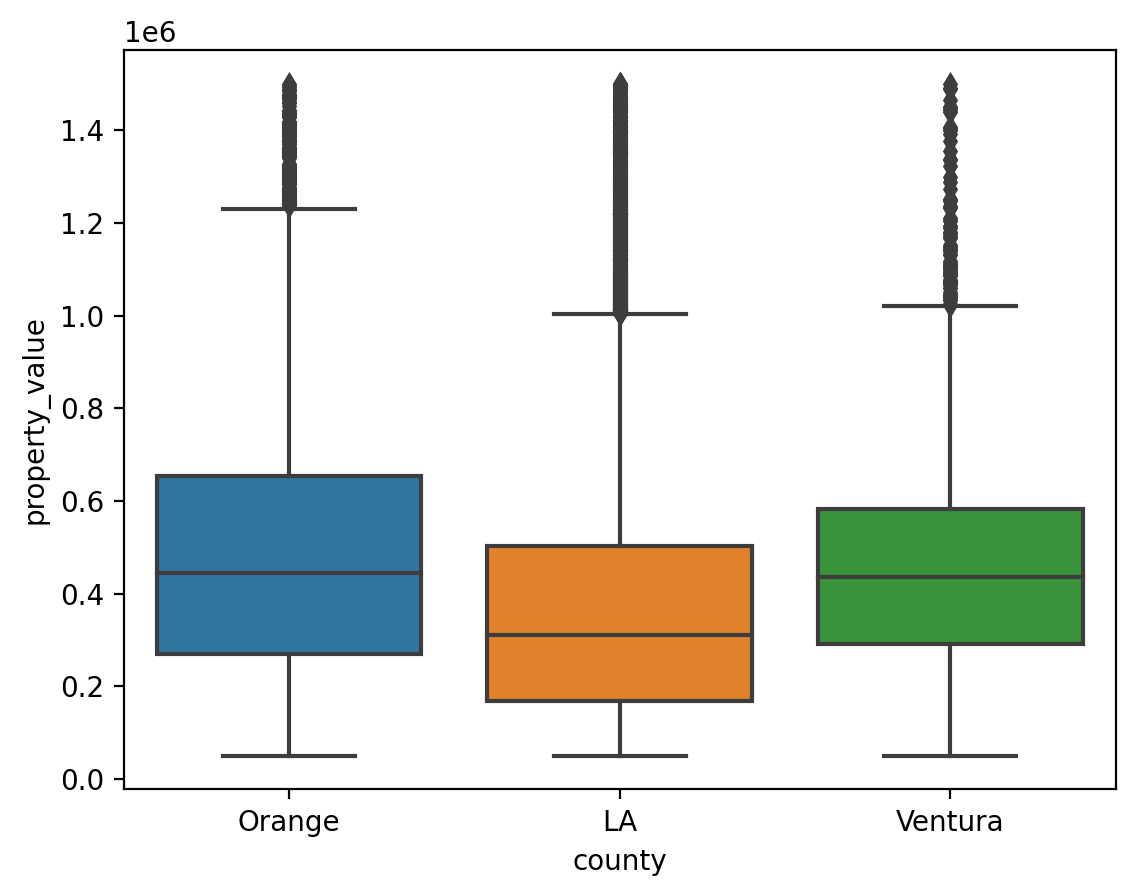

In [22]:
explore_bivariate_cat_to_cont_target(train, 'property_value',
                                     cat_cols=explore_utils.get_cat_and_cont_cols(train)[0])

Insights:
- Categorize bathrooms fro modeling to:
    - 1-2 bathrooms (~300k avg property value)
    - 2.5-3 bathrooms (~515k avg property value)
    - 3.5-4 bathrooms (~800k avg property value)
- Bedrooms could be worth modeling on as a categorical variable
- County doesn't tell us a lot on property value, but I could later explore zipcodes

**Which features appear to relate to property value the most?**

Visualize

In [23]:
def plot_target_heatmap(df):
    sns.set_style('white')
    plt.figure(figsize=(2,3))
    plt.title('Feature Correlations to Property Value', fontsize=10, pad=10)

    ax = sns.heatmap(df.corr()['property_value'].sort_values(ascending=False).to_frame().iloc[1:,:],
                     linewidths=.5, annot=True, cmap='RdYlGn', vmin=-1, vmax=1, square=True,
                    yticklabels=['SqFt', 'Bathrooms','Bedrooms','Age (years)'],
                    xticklabels=['Propety Value'])

    plt.tick_params(axis='both', which='both', bottom=False, left=False)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=6) 
    cbar.set_ticks([-1, -.5, 0, .5, 1])

    plt.show()

/var/folders/hg/jdcrdn3s5s3ddyrj47p9s7lh0000gn/T/ipykernel_18028/84088381.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df.corr()['property_value'].sort_values(ascending=False).to_frame().iloc[1:,:],


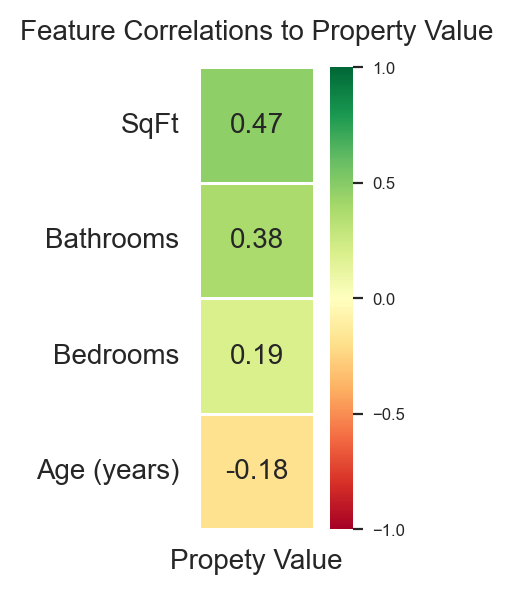

In [24]:
plot_target_heatmap(train)

Text(27.40625, 0.5, 'Property\nValue')

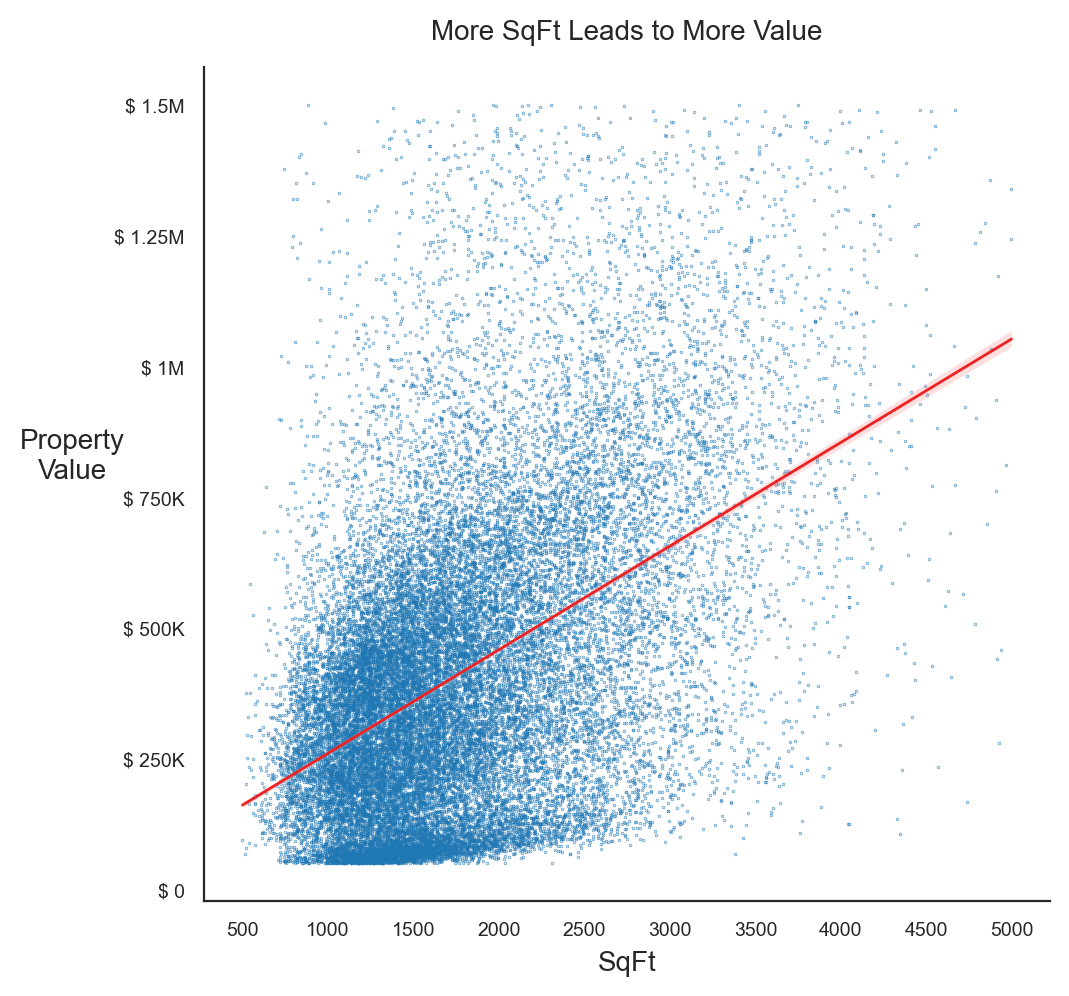

In [25]:
sns.lmplot(data=train, x='sqft', y='property_value', 
           scatter_kws = {'s':.05},
           line_kws = {'linewidth':1, 'color':'#EE2222'})

plt.title('More SqFt Leads to More Value', fontsize=10, pad=10)
plt.xticks(ticks=np.arange(500, 5001, 500), fontsize=7)
plt.xlabel('SqFt', fontsize=10)
plt.yticks(ticks=np.arange(0, 1_500_001, 250_000),
           labels=['$ 0', '$ 250K', '$ 500K', '$ 750K', '$ 1M', '$ 1.25M', '$ 1.5M'],
           fontsize=7)
plt.ylabel('Property\nValue', rotation=0, fontsize=10, labelpad=15)

In [26]:
def plot_sqft_to_value(df):
    sns.lmplot(data=df, x='sqft', y='property_value', height=4,
               scatter_kws = {'s':.001, 'alpha': 1},
               line_kws = {'linewidth':1, 'color':'#EE2222'})

    plt.title('More SqFt Leads to More Value', fontsize=9, pad=10)
    plt.xticks(ticks=np.arange(500, 5001, 500), fontsize=7)
    plt.xlabel('SqFt', fontsize=9)
    plt.yticks(ticks=np.arange(0, 1_500_001, 250_000),
               labels=['$ 0', '$ 250K', '$ 500K', '$ 750K', '$ 1M', '$ 1.25M', '$ 1.5M'],
               fontsize=7)
    plt.ylabel('Property\nValue', rotation=0, fontsize=9, labelpad=12)

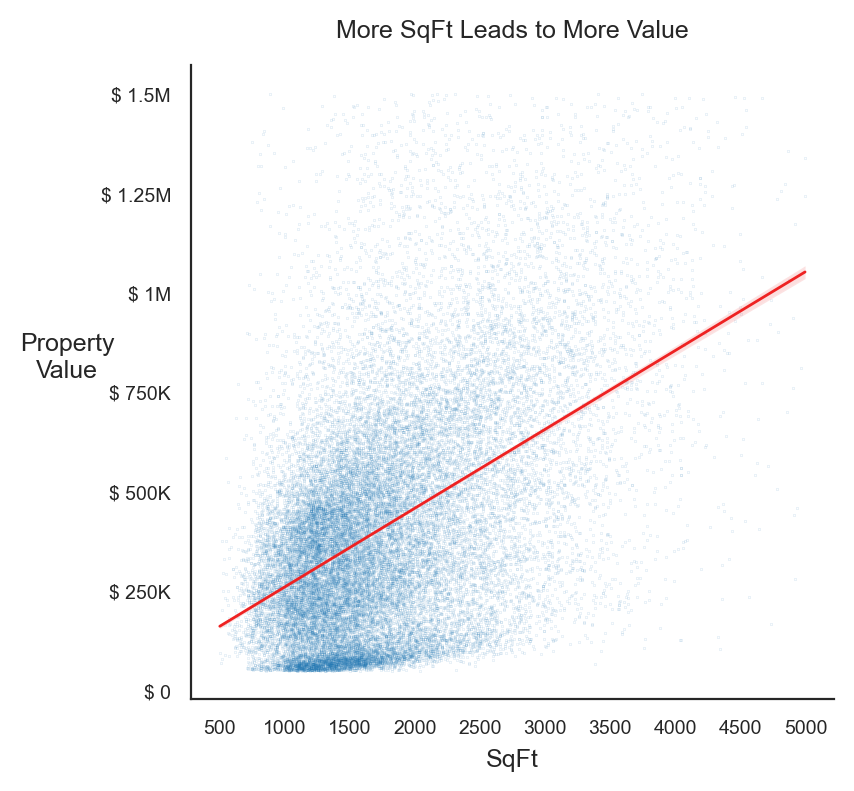

In [27]:
plot_sqft_to_value(train)

- Statistical test
    * Pearson correlation test
    * Hypotheses and significance level
        * $H_0$: There is no linear relationship between property value and square footage.
        * $H_a$: There is some linear relationship between property value and square footage.
        * $\alpha = .05$
- Verify Assumptions
    Normality: distributions are right skewed but we can bypass this with large sample sizes
    
Test:

In [28]:
r, p = stats.pearsonr(train['property_value'], train['sqft'])
r, p

(0.4692160238974564, 0.0)

There's signicant evidence that there is a moderate positive correlation between property value and square footage.

**Do home values vary significantly among the 3 counties?**

Visualize

In [29]:
def plot_value_average_by_county(df, target, category):
    
    plt.figure(figsize=(4,3))
    
    target_label = ' '.join([word.capitalize() for word in target.split('_')])
    cat_label = ' '.join([word.capitalize() for word in category.split('_')])
    
    sns.barplot(data=df, x=category, y=target, errorbar=None,
            order=train.groupby(category)[target].mean().sort_values().index,
            color='#33AA33')

    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'$ {str(round(p.get_height(), -3))[:3]}K', 
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)

    plt.title(f'Average {target_label} by {cat_label}', fontsize=10, pad=10)

    plt.xlabel(cat_label, fontsize=8, labelpad=5)
    plt.xticks(fontsize=7)

    plt.ylabel('\n'.join([word.capitalize() for word in target.split('_')]),
               rotation=0, fontsize=8, labelpad=15)
    plt.yticks(ticks=np.arange(0, 600_001, 100_000),
               labels=['', '$ 100K', '$ 200K', '$ 300K', '$ 400K', '$ 500K', '$ 600K'],
               fontsize=7)

    plt.tick_params(axis='both', which='both', bottom=False, left=False)

    sns.despine()
    plt.show()

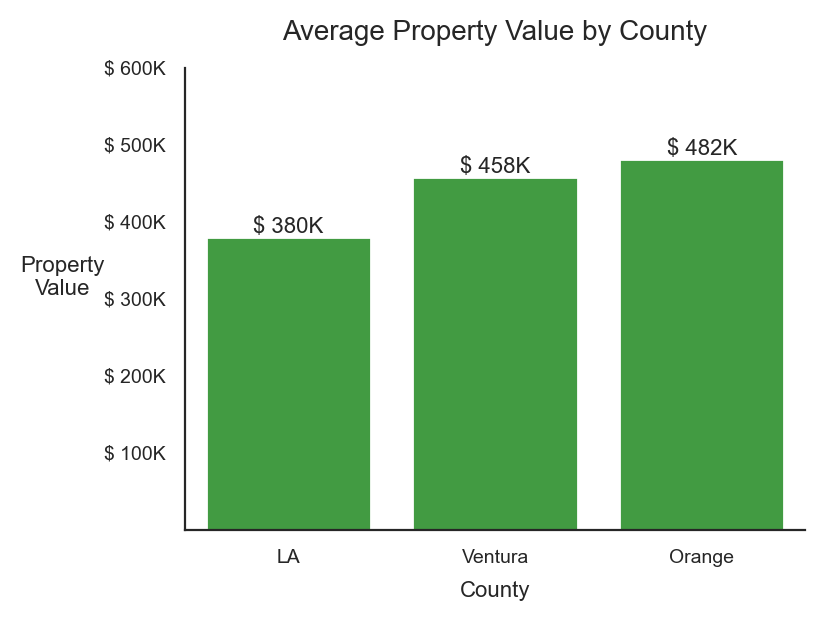

In [30]:
plot_value_average_by_county(train, 'property_value', 'county')

- Statistical test
    * ANOVA T-Test
    * Hypotheses and significance level
        * $H_0$: There is no difference in property value for homes in each county.
        * $H_a$: There is a difference in property value for homes in each county.
        * $\alpha = .05$
    * verify assumptions
        * Independence: Assumption met
        * Normality: Property values are right skewed, but assumption is met with large sample sizes
        * Equal Variances: Check with Levene's test
            * Variances are not equal, so we will set `equal_var=False` for the test

In [31]:
print(f"value variance for LA: {train[train['county']=='LA']['property_value'].var()}")
print(f"value variance for Orange: {train[train['county']=='Orange']['property_value'].var()}")
print(f"value variance for Ventura: {train[train['county']=='Ventura']['property_value'].var()}")
stat_levene, p_levene = stats.levene(train[train['county']=='LA']['property_value'],
                                     train[train['county']=='Orange']['property_value'],
                                     train[train['county']=='Ventura']['property_value'])
print(f'''A p value of {p_levene:.2e}, which is less than .05, indicates that our sample variances between
            churners and non-churners are not equal''')

value variance for LA: 79775868736.52249
value variance for Orange: 84330578198.54753
value variance for Ventura: 62985626714.291954
A p value of 2.45e-24, which is less than .05, indicates that our sample variances between
            churners and non-churners are not equal


Run test

In [32]:
stat, p_val = stats.f_oneway(train[train['county']=='LA']['property_value'],
                                     train[train['county']=='Orange']['property_value'],
                                     train[train['county']=='Ventura']['property_value'])
stat, p_val

(424.4714260770215, 1.2676805327165247e-182)

There's signicant evidence that there is some relationship between property value and bedrooms. However, the visuals show us this relationship isn't strong.

**Do home values vary significantly among those with X bathrooms?**

Visualize

In [33]:
def plot_value_average_by_bathrooms(df, target, category):
    
    plt.figure(figsize=(6,3))
    
    target_label = ' '.join([word.capitalize() for word in target.split('_')])
    cat_label = ' '.join([word.capitalize() for word in category.split('_')])
    
    sns.barplot(data=df, x=category, y=target, errorbar=None, color='#33AA33')

    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'$ {str(round(p.get_height(), -3))[:3]}K', 
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)

    plt.title(f'Average {target_label} by {cat_label}', fontsize=10, pad=10)

    plt.xlabel(cat_label, fontsize=8, labelpad=5)
    plt.xticks(fontsize=7)

    plt.ylabel('\n'.join([word.capitalize() for word in target.split('_')]),
               rotation=0, fontsize=8, labelpad=15)
    plt.yticks(ticks=np.arange(0, 900_001, 100_000),
               labels=['', '$ 100K', '$ 200K', '$ 300K', '$ 400K', '$ 500K',
                       '$ 600K', '$ 700K', '$ 800K', '$ 900K'],
               fontsize=7)

    plt.tick_params(axis='both', which='both', bottom=False, left=False)

    sns.despine()
    plt.show()

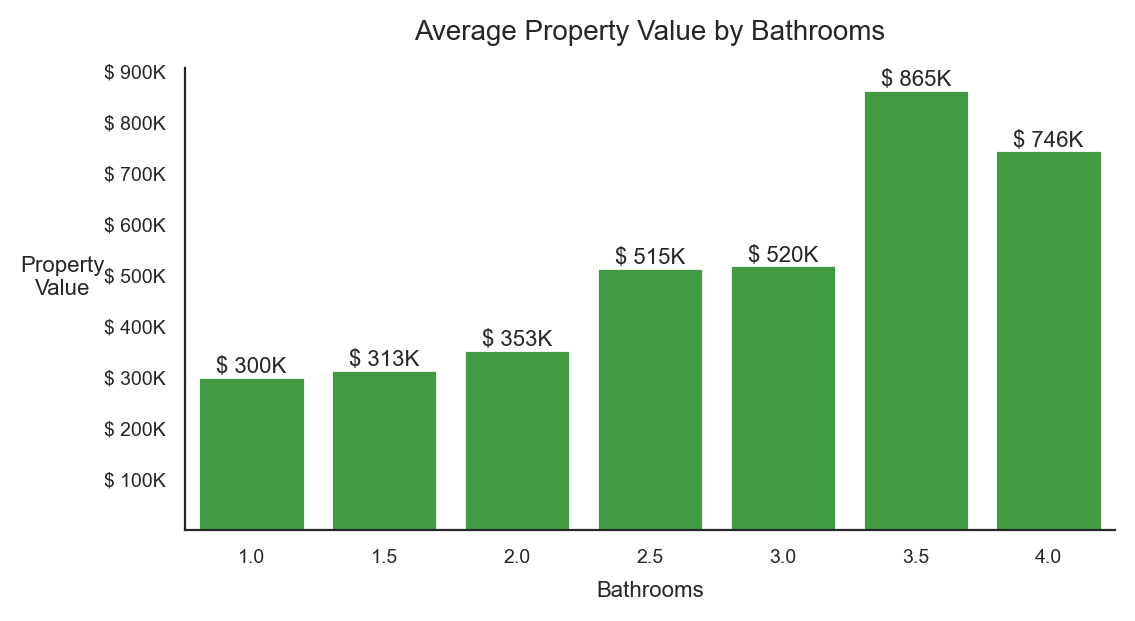

In [34]:
plot_value_average_by_bathrooms(train, 'property_value', 'bathrooms')

**Do home values vary significantly among those with X bedrooms?**

Visualize

In [35]:
def plot_value_average_by_bedrooms(df, target, category):
    
    plt.figure(figsize=(6,3))
    
    target_label = ' '.join([word.capitalize() for word in target.split('_')])
    cat_label = ' '.join([word.capitalize() for word in category.split('_')])
    
    sns.barplot(data=df, x=category, y=target, errorbar=None, color='#33AA33')

    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'$ {str(round(p.get_height(), -3))[:3]}K', 
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)

    plt.title(f'Average {target_label} by {cat_label}', fontsize=10, pad=10)

    plt.xlabel(cat_label, fontsize=8, labelpad=5)
    plt.xticks(fontsize=7)

    plt.ylabel('\n'.join([word.capitalize() for word in target.split('_')]),
               rotation=0, fontsize=8, labelpad=15)
    plt.yticks(ticks=np.arange(0, 650_001, 100_000),
               labels=['', '$ 100K', '$ 200K', '$ 300K', '$ 400K', '$ 500K',
                       '$ 600K'],
               fontsize=7)

    plt.tick_params(axis='both', which='both', bottom=False, left=False)

    sns.despine()
    plt.show()

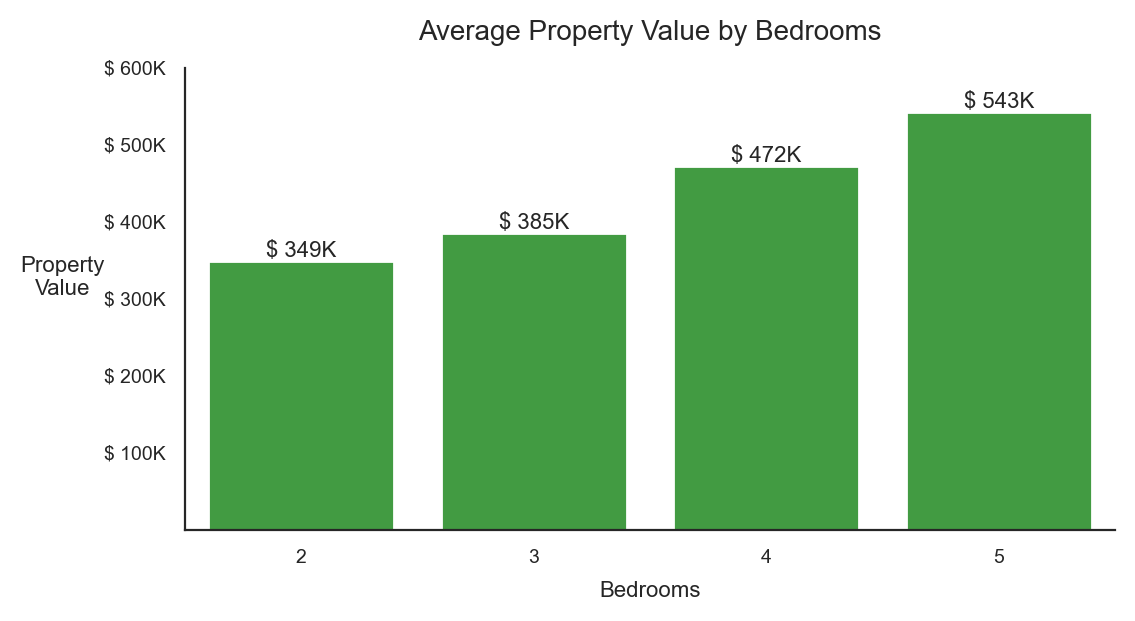

In [36]:
plot_value_average_by_bedrooms(train, 'property_value', 'bedrooms')

- Statistical test
    * ANOVA T-Test
    * Hypotheses and significance level
        * $H_0$: There is no difference in property value for homes in each county.
        * $H_a$: There is a difference in property value for homes in each county.
        * $\alpha = .05$
    * verify assumptions
        * Independence: Assumption met
        * Normality: Property values are right skewed, but assumption is met with large sample sizes
        * Equal Variances: Check with Levene's test
            * Variances are not equal, so we will set `equal_var=False` for the test

In [37]:
print(f"value variance for 2 bedrooms: {train[train['bedrooms']==2]['property_value'].var()}")
print(f"value variance for 3 bedrooms: {train[train['bedrooms']==3]['property_value'].var()}")
print(f"value variance for 4 bedrooms: {train[train['bedrooms']==4]['property_value'].var()}")
print(f"value variance for 5 bedrooms: {train[train['bedrooms']==5]['property_value'].var()}")
stat_levene, p_levene = stats.levene(train[train['bedrooms']==2]['property_value'],
                                     train[train['bedrooms']==3]['property_value'],
                                     train[train['bedrooms']==4]['property_value'],
                                     train[train['bedrooms']==5]['property_value'])
print(f'''A p value of {p_levene:.2e}, which is less than .05, indicates that our sample variances between
            churners and non-churners are not equal''')

value variance for 2 bedrooms: 62972253221.303154
value variance for 3 bedrooms: 72677437730.732
value variance for 4 bedrooms: 91883967767.4036
value variance for 5 bedrooms: 102513821252.43073
A p value of 3.18e-103, which is less than .05, indicates that our sample variances between
            churners and non-churners are not equal


Run test

In [38]:
stat, p_val = stats.f_oneway(train[train['bedrooms']==2]['property_value'],
                             train[train['bedrooms']==3]['property_value'],
                             train[train['bedrooms']==4]['property_value'],
                             train[train['bedrooms']==5]['property_value'])
stat, p_val

(408.2200356208768, 3.653893557815671e-260)

There's signicant evidence that there is some relationship between property value and bedrooms. However, the visuals show us this relationship isn't strong.

**Next Steps**

I want to investigate zipcode and location

In [39]:
train, _, _ = split_data(df, validate_size=.15, test_size=.15, 
                         stratify_col='county', random_state=123)

In [40]:
train

parcelid       id  bathrooms  bedrooms  sqft  fips  latitude  \
35445  14362226  1205298       2.50         3  2512  6059  33687974   
25232  14137692  1861110       3.00         5  2223  6059  33901579   
20581  14058820   518364       4.00         5  2168  6059  33685599   
27254  12169036   960930       1.00         2   954  6037  34180005   
36098  12346457  1543453       2.00         4  1229  6037  33912904   
...         ...      ...        ...       ...   ...   ...       ...   
22820  11161861   331105       3.00         4  2264  6037  34435360   
40700  13943404  2922194       2.50         3  1461  6059  33766774   
45684  17127633  2654760       2.00         3  1661  6111  34231068   
46917  14451947   982181       3.00         5  2756  6059  33430868   
4181   17256849   746772       2.00         4  2299  6111  34251200   

       longitude  regionidcity  regionidzip  property_value transaction_date  \
35445 -117663768         32380        96946          767135       2017-06-29   
25232 -117897737         24812        97043          288645       2017-05-18   
20581 -117951180         25218        96964          591995       2017-04-27   
27254 -118128163         30187        96265          453470       2017-05-26   
36098 -118113606          4406        96102          434377       2017-06-30   
...          ...           ...          ...             ...              ...   
22820 -118385857         54311        96401          415548       2017-05-08   
40700 -118004079         34780        96990          483708       2017-07-24   
45684 -119061944         51239        97089          293403       2017-08-17   
46917 -117627672         13693        96982          888343       2017-08-23   
4181  -118754906         27110        97118          707000       2017-01-29   

       age   county  
35445   22   Orange  
25232   52   Orange  
20581   53   Orange  
27254  105       LA  
36098   62       LA  
...    ...      ...  
22820   18       LA  
40700    7   Orange  
45684   51  Ventura  
46917   61   Orange  
4181    17  Ventura  

[31395 rows x 14 columns]

In [41]:
for col in train[['regionidzip', 'regionidcity']].columns:
    print(f'Number of {col}\'s: {train[col].nunique()}')

Number of regionidzip's: 372
Number of regionidcity's: 173
